In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import display

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='patent-analysis-413902')

In [ ]:
df = client.query("""
SELECT claims_localized, description_localized FROM `patents-public-data.patents.publications` where publication_number = 'US-2017172937-A1'  LIMIT 1
""").to_dataframe()

In [ ]:
description = df["description_localized"].iloc[0][0]["text"]
claims = df["claims_localized"].iloc[0][0]["text"]

claims

In [ ]:
from kaggle_secrets import UserSecretsClient
import openai

# Pulling API key from Kaggle's Add-ons
user_secrets = UserSecretsClient()
openai_api_key = user_secrets.get_secret("openai_api_key")

# Setting OpenAI API key
openai.api_key = openai_api_key

In [ ]:
def get_patent_data(client, publication_number):
    try:
        sql = f"""
        SELECT claims_localized, description_localized
        FROM `patents-public-data.patents.publications`
        WHERE publication_number = 'US-2017172937-A1'
        LIMIT 1
        """
        
        df = client.query(sql).to_dataframe()
        description = df["description_localized"].iloc[0][0]["text"]
        claims = df["claims_localized"].iloc[0][0]["text"]
        return claims, description
    except Exception as e:
        print(f"Failed in get_patent_data: {e}")
            

In [ ]:
publication_number = publication_number
claims, description = get_patent_data(client, publication_number)
print(f"Claims obtained from patent: {publication_number}\n{claims}\n")

In [ ]:
def generate_claim(claims: str) -> str:
    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            messages=[
                {"role": "system", "content": "The following is a patent description"},
                {"role": "user", "content": claims},
                {"role": "system", "content": "Generate new patent claims based on the previous patent description that isn't already claimed, filling the gap in the claims."},
                {"role": "user", "content": claims},
            ],
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Failed in generate_claim: {e}")

In [ ]:
new_claims = generate_claim(claims)
print(f"Generated Claims by the model:\n{new_claims}\n")

In [ ]:
def generate_patent_description(new_claims: str, description: str) -> str:
    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            messages=[
                {"role": "system", "content": "Generate a patent description based on the following patent claim"},
                {"role": "user", "content": new_claims},
                {"role": "system", "content": "Make sure the patent does not conflict with the following patent description"},
                {"role": "user", "content": description},
            ],
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Failed in generate_patent_description: {e}")

In [ ]:
import textwrap

def reduce_text_size(text: str, max_tokens: int = 2048) -> str:
    tokens = text.split(' ')
    if len(tokens) > max_tokens:
        return ' '.join(tokens[:max_tokens])
    else:
        return text

description = reduce_text_size(description)
new_claims = reduce_text_size(new_claims)

new_patent_desc = generate_patent_description(new_claims, description)
print(f"Generated Patent Description: {new_patent_desc}")

Pulling Multiple Patents from an Assignee in a Specific CPC

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='patent-analysis-413902')

In [ ]:
from google.cloud import bigquery

# create a BigQuery client
client = bigquery.Client(project='patent-analysis-413902')

sql = """
SELECT 
    assignee.name AS assignee_name
FROM
    `patents-public-data.patents.publications` AS pubs,
    UNNEST(pubs.assignee_harmonized) AS assignee
WHERE
    pubs.country_code = 'US'
LIMIT 10
"""

query_job = client.query(sql)
results = query_job.result()

assignees = [row.assignee_name for row in results]
print(assignees[:10])  # print first 10 assignee names

In [ ]:
query_job = client.query(sql)
results = query_job.result()

assignees = [row.assignee_name for row in results]
print(assignees[:10])  # print first 10 assignee names

In [ ]:
from google.cloud import bigquery

# create a BigQuery client
client = bigquery.Client(project='patent-analysis-413902')

sql = """
SELECT
    pubs.publication_number, 
    pubs.abstract_localized[OFFSET(0)].text AS abstract, 
    ARRAY_TO_STRING(ARRAY(SELECT text FROM UNNEST(pubs.claims_localized)), ' ') AS claim, 
    res.top_terms, 
    res.embedding_v1 AS embedding
FROM (
    SELECT
        publication_number
    FROM
        `patents-public-data.patents.publications`
    WHERE 
        EXISTS (
            SELECT 1 
            FROM 
                UNNEST(assignee_harmonized), 
                UNNEST(cpc) 
            WHERE 
                name = 'SCHLUMBERGER TECHNOLOGY CORP' 
                AND code LIKE 'E21B%'
        )
    LIMIT 10
) as unique_pubs
JOIN `patents-public-data.patents.publications` as pubs
    ON pubs.publication_number = unique_pubs.publication_number
JOIN `patents-public-data.google_patents_research.publications` as res
    ON pubs.publication_number = res.publication_number
    """

query_job = client.query(sql)
results = query_job.result()

for row in results:
    print(row)

In [ ]:
import json

results = query_job.result()

# Initialize an empty list to hold all patent dictionaries
patents = []

for row in results:
    # Associate data with field names
    row_dict = {
        'publication_number': row[0],
        'abstract': row[1],
        'claims': row[2],
        'top_terms': row[3],
        'embeddings': row[4]
    }
    
    # Append the dictionary to the list of patents
    patents.append(row_dict)

# Print the data in JSON format with indentation
print(json.dumps(patents, indent=4))

In [ ]:
!pip install google-colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
query_job = client.query(sql)
results = query_job.result()
results_list = [row for row in results]

for row in results_list:
    print(row)

# Converting to DataFrame and save to .csv file
df = pd.DataFrame(results_list, columns=["publication_number", "abstract", "claim", "top_terms", "embedding"])

df.to_csv('/kaggle/working/query_result.csv', index=False)

In [ ]:
from google.cloud import bigquery

# create a BigQuery client
client = bigquery.Client(project='patent-analysis-413902')

sql = """
SELECT
    unique_pubs.publication_number, 
    abstract_text.text AS abstract, 
    claims_text.text AS claim, 
    res.top_terms, 
    res.embedding_v1 AS embedding
FROM (
    SELECT
        publication_number
    FROM
        `patents-public-data.patents.publications`
    WHERE 
        EXISTS (
            SELECT 1 
            FROM 
                UNNEST(assignee_harmonized), 
                UNNEST(cpc) 
            WHERE 
                name = 'SCHLUMBERGER TECHNOLOGY CORP' 
                AND code LIKE 'E21B%'
        )
    LIMIT 10
) AS unique_pubs
INNER JOIN `patents-public-data.patents.publications` AS pubs
    ON unique_pubs.publication_number = pubs.publication_number
CROSS JOIN UNNEST(pubs.abstract_localized) AS abstract_text 
CROSS JOIN UNNEST(pubs.claims_localized) AS claims_text 
INNER JOIN `patents-public-data.google_patents_research.publications` AS res
    ON pubs.publication_number = res.publication_number
"""

query_job = client.query(sql)
results = query_job.result()

for row in results:
    print(row)

In [ ]:
sql = """
SELECT 
    pubs.publication_number, 
    abstract_text.text AS abstract, 
    claims_text.text AS claim, 
    res.top_terms, 
    res.embedding_v1 AS embedding 
FROM 
    `patents-public-data.patents.publications` AS pubs, 
    UNNEST(pubs.assignee_harmonized) AS assignee, 
    UNNEST(pubs.cpc) AS cpc_item, 
    UNNEST(pubs.abstract_localized) AS abstract_text, 
    UNNEST(pubs.claims_localized) AS claims_text 
JOIN 
    `patents-public-data.google_patents_research.publications` AS res 
ON 
    pubs.publication_number = res.publication_number 
WHERE 
    assignee.name = 'SCHLUMBERGER TECHNOLOGY CORP' 
    AND cpc_item.code LIKE 'E21B%' 
LIMIT 10
"""

query_job = client.query(sql)
results = query_job.result()

for row in results:
    print(row)

In [ ]:
from itertools import islice

# Print first 1 patents from processed data
for row in islice(all_data, 1):
    print(row)

In [ ]:
!pip install sklearn nltk pyLDAvis

In [ ]:
from google.cloud import bigquery

# create a BigQuery client
client = bigquery.Client(project='patent-analysis-413902')

In [ ]:
sql = """
SELECT 
  pubs.publication_number,
  abstract.text AS abstract,
  claims.text AS claim,
  top_terms,
  embedding_v1 AS embedding
FROM 
  `patents-public-data.patents.publications` AS pubs
INNER JOIN 
  `patents-public-data.google_patents_research.publications` AS res ON 
    pubs.publication_number = res.publication_number
, UNNEST(pubs.abstract_localized) AS abstract
, UNNEST(pubs.claims_localized) AS claims
WHERE
  EXISTS (
    SELECT 1
    FROM UNNEST(pubs.assignee_harmonized) AS assignee
    WHERE assignee.name = 'SCHLUMBERGER TECHNOLOGY CORP'
  )
  AND EXISTS (
    SELECT 1
    FROM UNNEST(pubs.cpc) AS cpc_item
    WHERE cpc_item.code LIKE 'E21B%'
  )
  AND pubs.publication_date >= DATE('2020-01-01')
LIMIT 10
"""

query_job = client.query(sql)

In [ ]:
# Execute the query and convert the result into DataFrame
df = query_job.to_dataframe()

# Print only the first 10 patents
print(df.head(10))

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install google-cloud-bigquery google-colab

In [ ]:
!pip install PyDrive

In [ ]:
import pandas as pd
import pickle
from google.colab import files

In [ ]:
import os

# Directory where the dataset is expected to be found
directory_path = '/kaggle/input/query-result'

# List all files in the directory to verify the presence of your file
print("Files in the directory:", os.listdir(directory_path))

In [ ]:
with open(file_path, 'r') as file:
    for line in file:
        # Process each line as needed
        print(line)

Pulling Data From a Patent Dataset Saved in Kaggle env

In [ ]:
import ast
from pathlib import Path

class MockQueryJob:
    def __init__(self, dataset_path: str):
        self.dataset_path = Path(dataset_path) 

    def _parse_record(self, record: str) -> dict:
        # Split content into tuple and dictionary parts
        tuple_part, dict_part = record.rsplit(", {", 1)
        # Add back the dropped characters
        tuple_part = tuple_part + ","
        dict_part = "{" + dict_part
        content = tuple_part + dict_part

        # Convert to Python structures
        try:
            record_tuple = ast.literal_eval(content)
        except:
            print(f"Unable to parse the following line:\n{content}")
            raise

        return record_tuple
    
    def result(self) -> list:
        if not self.dataset_path.is_file():
            raise FileNotFoundError(f"No such file: '{self.dataset_path}'")
        
        try:
            with open(self.dataset_path, 'r') as file:
                records = [record for record in file.read().split('\n\n') if record]
                return [self._parse_record(record) for record in records]
        except Exception as e:
            print(f"Error occurred: {e}")
            return []
# Usage
file_name = "SCHLUMBERGER TECHNOLOGY CORP.txt"
dataset_path = f'/kaggle/input/schlumberger-technology-corp-dataset/{file_name}'

query_job = MockQueryJob(dataset_path)
results = query_job.result()

for row in results:
    print(row)

In [ ]:
import ast  # Use ast.literal_eval to safely evaluate the string to a Python object

# Initialize an empty list to hold each "row" of data
results = []

with open('path/to/your/text/file.txt', 'r') as file:
    for line in file:
        # Safely evaluate the string representation of the tuple to a Python object
        data_tuple = ast.literal_eval(line.strip())
        
        # Assuming the structure of the tuple is consistent with your example
        publication_number, abstract, claim, top_terms, embedding = data_tuple
        
        # Structure the data as a dictionary
        row = {
            'publication_number': publication_number,
            'abstract': abstract,
            'claim': claim,
            'top_terms': top_terms,
            'embedding': embedding
        }
        
        results.append(row)

# Now 'results' contains a list of dictionaries, each representing a row of data

In [ ]:
import requests
from bs4 import BeautifulSoup

# Placeholder list of patents for demonstration; replace with actual patent numbers
patents = ['US-2015044004-A1']  # Simulating 10 patents for the example

for patent in patents:
    url = f'https://patents.google.com/patent/US20150044004A1/en?oq=US-2015044004-A1'
    soup = BeautifulSoup(requests.get(url).content, 'html.parser')

    # Initialize variables to store concatenated CPC codes and definitions
    cpc_codes = []
    definitions = []

    for code in soup.select('[itemprop="Code"]:has(~ meta[itemprop="Leaf"])'):
        cpc_code = code.text.strip()
        definition = code.find_next('span').text.strip()

        # Append each code and definition to the lists
        cpc_codes.append(cpc_code)
        definitions.append(definition)

    # Combine all codes and definitions for the current patent into comma-separated strings
    cpc_codes_str = ", ".join(cpc_codes)
    definitions_str = ", ".join(definitions)

    # Print the consolidated data for the current patent
    print(f'Patent: {patent}, CPC: {cpc_codes_str}, Definition: {definitions_str}')
    print('-' * 80)

    # Specify the output path for the updated CSV
    output_path = '/kaggle/working/updated_query_result.csv'

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_path, index=False)

Scraping CPCs from Google Patents

In [ ]:
import requests
from bs4 import BeautifulSoup

def format_patent_url(publication_number):
    collapsed_number = publication_number.replace("-", "")
    if collapsed_number.startswith("US20"):
        first_part = collapsed_number[:6] + "0" + collapsed_number[6:]
    else:
        first_part = collapsed_number
    second_part = publication_number
    url = f'https://patents.google.com/patent/{first_part}/en?oq={second_part}'
    return url

def fetch_cpc_info(publication_number):
    url = format_patent_url(publication_number)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    cpc_codes = []
    definitions = []
    
    for code in soup.select('[itemprop="Code"]:has(~ meta[itemprop="Leaf"])'):
        cpc_codes.append(code.text.strip())
        definition_span = code.find_next('span')
        definitions.append(definition_span.text.strip() if definition_span else "No definition available")
    
    return cpc_codes, definitions

publication_numbers = [
    'US2017114613A1',
    'US2017269262A1',
    'US2021032972A1',
    'US2008236840A1',
    'US2008314589A1',
    'US2015044004A1',
    'US2015135816A1',
    'US11156742B2',
    'US2023333275A1',
    'US9797235B2'
]

for publication_number in publication_numbers:
    cpc_codes, definitions = fetch_cpc_info(publication_number)
    print(f"Patent: {publication_number}")
    print(f"CPC Codes: {', '.join(cpc_codes)}")
    print(f"Definitions: {', '.join(definitions)}")
    print('-' * 100)



Scraping Citations from Google Patents

In [ ]:
import requests
from bs4 import BeautifulSoup
import json

def format_patent_url(publication_number):
    collapsed_number = publication_number.replace("-", "")
    if collapsed_number.startswith("US20"):
        first_part = collapsed_number[:6] + "0" + collapsed_number[6:]
    else:
        first_part = collapsed_number
    second_part = publication_number
    url = f'https://patents.google.com/patent/{first_part}/en?oq={second_part}'
    return url

def fetch_citation_info(publication_number):
    url = format_patent_url(publication_number)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Fetch backward citations
    backward_citations = soup.select('tr[itemprop="patentCitations"] a')
    backward_cites = [citation['href'] for citation in backward_citations if 'href' in citation.attrs]
    
    # Fetch forward citations
    forward_citations = soup.select('tr[itemprop="citedBy"] a')
    forward_cites = [citation['href'] for citation in forward_citations if 'href' in citation.attrs]
    
    return forward_cites, backward_cites

# Example usage
publication_numbers = [
    'US2017114613A1',
    'US2017269262A1',
    'US2021032972A1',
    'US2008236840A1',
    'US2008314589A1',
    'US2015044004A1',
    'US2015135816A1',
    'US11156742B2',
    'US2023333275A1',
    'US9797235B2'
]

for publication_number in publication_numbers:
    forward_cites, backward_cites = fetch_citation_info(publication_number)
    print(f"Patent: {publication_number}")
    print(f"Forward Citations: {forward_cites}")
    print(f"Backward Citations: {backward_cites}")
    print('-' * 100)


In [ ]:
!pip install selenium webdriver_manager

In [ ]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

def fetch_cited_by_with_selenium(publication_number):
    # Setup Chrome WebDriver with a specific version
    driver = webdriver.Chrome(ChromeDriverManager(version='114.0.5735.90').install())

    # Construct URL and open the page
    url = f'https://patents.google.com/patent/US20150044004A1/en?oq=US-2015044004-A1'
    driver.get(url)

    # Include your logic here to interact with the webpage and extract necessary information

    # Don't forget to close the driver after your operations are done
    driver.quit()

# Example usage
publication_number = 'US2015044004A1'  # Example publication number
fetch_cited_by_with_selenium(publication_number)


In [ ]:
from bs4 import BeautifulSoup

# Assuming 'html_content' contains the outer HTML of the entire backward citations table or section
# For demonstration, let's say it looks like this:
html_content = """
<div class="backward-citations-container">
    <a id="link" href="/patent/US2774497A/en?oq=US-2015044004-A1&amp;peid=612cbc7994660%3A261%3A87f6ee4e" class="style-scope state-modifier">US2774497A</a>
    <a id="link" href="/patent/US1234567B/en?oq=US-2015044004-A1&amp;peid=612cbc7994660%3A261%3A87f6ee4e" class="style-scope state-modifier">US1234567B</a>
    <!-- More <a> tags for other cited patents -->
</div>
"""

soup = BeautifulSoup(html_content, 'html.parser')

# Select all <a> tags within the container that have the class 'style-scope state-modifier'
# Adjust the selector as needed based on the actual structure and classes/ids
cited_patents_links = soup.select('div.backward-citations-container a.style-scope.state-modifier')

# Extract the text (publication number) from each <a> tag
cited_patents = [link.text for link in cited_patents_links]

print("Cited patents include:")
for patent in cited_patents:
    print(patent)



In [ ]:
def fetch_citations_html(publication_number):
    url = format_patent_url(publication_number)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    citations = []
    # Assuming 'itemprop="citations"' identifies the citations table
    for row in soup.select('tr[itemprop="citations"]'):
        publication_number = row.find('td', class_='publication_number').text.strip()
        priority_date = row.find('td', class_='priority_date').text.strip()
        publication_date = row.find('td', class_='publication_date').text.strip()
        assignee = row.find('td', class_='assignee').text.strip()
        title = row.find('td', class_='title').text.strip()

        citations.append({
            'Publication Number': publication_number,
            'Priority Date': priority_date,
            'Publication Date': publication_date,
            'Assignee': assignee,
            'Title': title
        })

    return citations


In [ ]:
# Assuming the fetch_citation_info function is defined as discussed, and it returns the citations correctly

publication_numbers = [
    'US2017114613A1',
    'US2017269262A1',
    'US2021032972A1',
    'US2008236840A1',
    'US2008314589A1',
    'US2015044004A1',
    'US2015135816A1',
    'US11156742B2',
    'US2023333275A1',
    'US9797235B2'
]

for publication_number in publication_numbers:
    citation_info = fetch_citation_info(publication_number)
    print(f"Patent: {publication_number}")
    print("Forward Citations (Non-Family):", ", ".join(citation_info['citedBy']) if citation_info['citedBy'] else "None")
    print("Backward Citations (Non-Family):", ", ".join(citation_info['patentCitations']) if citation_info['patentCitations'] else "None")
    print('-' * 100)


Appending the CPC and Definitions to the existing .csv

In [ ]:
import pandas as pd

# Assuming 'fetch_cpc_info' function is already defined

# Step 1: Read the existing CSV file into a DataFrame
input_path = '/kaggle/input/query-result/query_result.csv'  # Update this path to your actual file location
df = pd.read_csv(input_path)

# Initialize lists to store CPC codes and definitions for all patents
all_cpc_codes = []
all_definitions = []

# Assuming your DataFrame has a column 'publication_number' with patent numbers
for publication_number in df['publication_number']:
    cpc_codes, definitions = fetch_cpc_info(publication_number)
    
    # Join the CPC codes and definitions into comma-separated strings
    cpc_codes_str = ', '.join(cpc_codes)
    definitions_str = ', '.join(definitions)
    
    # Append the joined strings to the lists
    all_cpc_codes.append(cpc_codes_str)
    all_definitions.append(definitions_str)

# Add the CPC codes and definitions as new columns to the DataFrame
df['cpc'] = all_cpc_codes
df['definitions'] = all_definitions

# Specify the output path for the updated CSV
output_path = '/kaggle/working/cpc_query_result.csv'

# Save the updated DataFrame to a new CSV file
df.to_csv(output_path, index=False)

print(f"Updated CSV saved to {output_path}")



Loading the existing .csv data

In [ ]:
# Loading patent data file from Kaggle
import pandas as pd

# Define the file path
directory_path = '/kaggle/input/cpc-query-result'
file_name = 'cpc_query_result.csv'
file_path = f'{directory_path}/{file_name}'

# Load csv into DataFrame
results = pd.read_csv(file_path)


In [ ]:
import re
import nltk
import numpy as np
from gensim.models.phrases import Phrases
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models import Phrases
from sklearn.feature_extraction.text import TfidfVectorizer

Data preprocessing, n-gram training, appending

In [ ]:
# Define the stop words and lemmatizer
stop_words = set(stopwords.words('english'))
stop_words.update(["said", "state", "therein", "herein", "wherein", "includes", "included", "include", "least", 
                   "wherein", "method", "claim", "claims", "claimed", "device", "claimed_claim", "comprising", 
                   "consisting", "comprises", "comprise", "consist", "first", "second", "third", "invention", 
                   "thus", "means", "plurality", "introducing", "may", "new", "novel", "according", "use", 
                   "using", "used", "consists", "step", "while", "whilst", "based", "assembly", "one", "system", 
                   "systems", "value", "domain", "value", "unit", "member","portion"])  
stop_words.update([str(i) for i in range(51)])  # Add digits from 0 to 50 to stop_words
common_terms = ["sensor", "strain", "body", "carrier", "switch", "charge", "stage", "instant", "step", "equation", "material", "instantly"]
known_terms = ["Poisson's_ratio", "Young's_modulus"]

lemmatizer = WordNetLemmatizer()

# Define the cleaning patterns
remove_numbering = re.compile(r"\(\s*\d+\s*\)")
remove_extra_newlines = re.compile(r"\n\s*\n")

# Your SQL data
results = pd.read_csv(file_path)

all_data = []
all_abstracts = []
all_claims = []
all_abstract_bigrams = []
all_claim_bigrams = []
all_abstract_trigrams = []
all_claim_trigrams = []

def clean_and_tokenize(text):
    # Clean the text using the defined patterns
    text = re.sub(remove_numbering, '', text)
    text = re.sub(remove_extra_newlines, '\n', text)

    # Tokenize and lemmatize the text, only remove stopwords and punctuation
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(t) for t in tokens 
                      if t.lower() not in stop_words and t not in [',', '.', ':', ';', '(', ')']]

    # Further process to check if any number is the start of a sentence
    cleaned_text = " ".join(cleaned_tokens)
    sentences = cleaned_text.split('. ')
    cleaned_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if words[0].isdigit():
            words = words[1:]
        cleaned_sentences.append(" ".join(words))

    # Tokenize for the final result
    final_tokens = word_tokenize(" .".join(cleaned_sentences))

    return cleaned_sentences, final_tokens

def clean_data(text, known_terms):
    cleaned_text = text
    cleaned_text = re.sub(r"\b\ *_(\w)?\ *_\ *\b", " ", cleaned_text)   # clean _x_ and _ x _
    cleaned_text = re.sub(r"\b\ *_(\w)?\ *\b", " ", cleaned_text)   # clean _x and _ x
    cleaned_text = re.sub(r"\b\ *(\w)?_\ *\b", " ", cleaned_text)   # clean x_ and x _
    cleaned_text = re.sub(r"\b\w\b", " ", cleaned_text)   # clean standalone single letters
    cleaned_text = re.sub(r"Equation_= \[ - - \]", "", cleaned_text) # remove 'Equation_= [ - - ]'
    cleaned_text = re.sub(r"\ue89e", "", cleaned_text)  # remove '\ue89e' unicode character
    # at the end, make replacements for known terms
    for term in known_terms:
        cleaned_text = cleaned_text.replace(term.replace("_& #_", "'s_"), term)
    return cleaned_text

for index, row in results.iterrows():
    publication_number = row['publication_number']
    abstract = clean_data(row['abstract'], known_terms)
    claim = clean_data(row['claim'], known_terms)
    top_terms = row['top_terms']
    embedding = row['embedding']

    # Cleaning and tokenizing abstracts
    abstract = re.sub(remove_numbering, '', abstract)
    abstract = re.sub(remove_extra_newlines, '\n', abstract)
    _, abstract_tokens = clean_and_tokenize(abstract)
    abstract_tokens = [lemmatizer.lemmatize(t) for t in abstract_tokens 
                       if t.lower() not in stop_words and t not in [',', '.', ':', ';', '(', ')']]

    # Cleaning and tokenizing claims
    claim = re.sub(remove_numbering, '', claim)
    claim = re.sub(remove_extra_newlines, '\n', claim)
    _, claim_tokens = clean_and_tokenize(claim)
    claim_tokens = [lemmatizer.lemmatize(t) for t in claim_tokens 
                    if t.lower() not in stop_words and t not in [',', '.', ':', ';', '(', ')']]

    # Train the gensim bigram detector and detect bigrams
    bigram_transformer = Phrases([abstract_tokens, claim_tokens], min_count=1, threshold=2)
    abstract_bigrams = bigram_transformer[abstract_tokens]
    claim_bigrams = bigram_transformer[claim_tokens]

    # Train the gensim trigram detector and detect trigrams
    trigram_transformer = Phrases(bigram_transformer[abstract_tokens] + bigram_transformer[claim_tokens], min_count=1, threshold=3)
    abstract_trigrams = trigram_transformer[abstract_bigrams]
    claim_trigrams = trigram_transformer[claim_bigrams]

    # Append in the result
    all_data.append({
        'publication_number': publication_number,
        'abstract_bigrams': clean_data(' '.join(abstract_bigrams), known_terms),
        'claim_bigrams': clean_data(' '.join(claim_bigrams), known_terms),
        'abstract_trigrams': clean_data(' '.join(abstract_trigrams), known_terms),
        'claim_trigrams': clean_data(' '.join(claim_trigrams), known_terms),
        'top_terms': top_terms,
        'embedding': embedding
    })

    all_abstract_bigrams.append(abstract_bigrams)
    all_claim_bigrams.append(claim_bigrams)
    all_abstract_trigrams.append(abstract_trigrams)
    all_claim_trigrams.append(claim_trigrams)

In [1]:
# Loading patent data file from Kaggle
import pandas as pd

# Define the file path
directory_path = '/kaggle/input/cpc-query-result'
file_name = 'cpc_query_result.csv'
file_path = f'{directory_path}/{file_name}'

# Load csv into DataFrame
results = pd.read_csv(file_path)

In [2]:
# Import necessary libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
import pandas as pd

In [3]:
# Define stopwords, lemmatizer, and cleaning patterns
stop_words = set(stopwords.words('english')) | {"said", "state", "therein", "herein", "wherein", "includes", "included", "include", 
                                                "least", "wherein", "method", "claim", "claims", "claimed", "device", "claimed_claim", 
                                                "comprising", "consisting", "comprises", "comprise", "consist", "first", "second", 
                                                "third", "invention", "thus", "means", "plurality", "introducing", "may", "new", 
                                                "novel", "according", "use", "using", "used", "consists", "step", "while", "whilst", 
                                                "based", "assembly", "one", "system", "unit", "member", "portion"} | set(str(i) for i in range(51))
common_terms = {"sensor", "strain", "body", "carrier", "switch", "charge", "stage", "instant", "step", "value", "material", "instantly"}
known_terms = {"Poisson's_ratio", "Young's_modulus"}

lemmatizer = WordNetLemmatizer()

remove_numbering = re.compile(r"\(\s*\d+\s*\)")
remove_extra_newlines = re.compile(r"\n\s*\n")

def clean_and_tokenize(text):
    text = re.sub(remove_numbering, '', text)
    text = re.sub(remove_extra_newlines, '\n', text)
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(t) for t in tokens if t.lower() not in stop_words and t not in [',', '.', ':', ';', '(', ')']]
    return " ".join(cleaned_tokens)

def clean_data(text, known_terms):
    cleaned_text = text
    for term in known_terms:
        cleaned_text = cleaned_text.replace(term.replace("_& #_", "'s_"), term)
    # Apply additional cleaning rules as per your specifications
    cleaned_text = re.sub(r"\b\ *_(\w)?\ *_\ *\b", " ", cleaned_text)  # clean _x_ and _ x _
    cleaned_text = re.sub(r"\b\w\b", " ", cleaned_text)  # clean standalone single letters
    cleaned_text = re.sub(r"\ue89e", "", cleaned_text)  # remove '\ue89e' unicode character
    return cleaned_text

# Assuming 'results' DataFrame is loaded correctly with 'abstract' and 'claim' columns available
all_data = []
for index, row in results.iterrows():
    combined_text = f"{row['abstract']} {row['claim']}"
    cleaned_combined_text = clean_data(combined_text, known_terms)
    combined_tokens = clean_and_tokenize(cleaned_combined_text)
    all_data.append({
        'publication_number': row['publication_number'],
        'tokens': combined_tokens,
        'top_terms': row['top_terms'],
        'embedding': row['embedding']
    })
    print(f"Processed document for publication number: {row['publication_number']}")

# Generate bigrams and trigrams
tokens_only = [data['tokens'].split() for data in all_data]  # Splitting tokens for Phrases model
bigram_transformer = Phrases(tokens_only, min_count=1, threshold=2)
trigram_transformer = Phrases(bigram_transformer[tokens_only], min_count=1, threshold=3)

# Update tokens with bigrams and trigrams
for data in all_data:
    data['tokens'] = trigram_transformer[bigram_transformer[data['tokens'].split()]]
    print(f"Bigrams and Trigrams for publication number: {data['publication_number']}")
    print(data['tokens'][:10])  # Print first 10 tokens to review


Processed document for publication number: US-2017114613-A1
Processed document for publication number: US-2017269262-A1
Processed document for publication number: US-2021032972-A1
Processed document for publication number: US-2008236840-A1
Processed document for publication number: US-2008314589-A1
Processed document for publication number: US-2015044004-A1
Processed document for publication number: US-2015135816-A1
Processed document for publication number: US-11156742-B2
Processed document for publication number: US-2023333275-A1
Processed document for publication number: US-9797235-B2
Bigrams and Trigrams for publication number: US-2017114613-A1
['well', 're-stimulation_treatment', 'instantaneous_shut-in_pressure_ISIP', 'guide', 'design', 'execution', 'refracturing', 'stage', 'Pore', 'pressure']
Bigrams and Trigrams for publication number: US-2017269262-A1
['Consolidated', 'porous_medium_sample', 'method', 'manufacture', 'described', 'outer_tube_softening_temperature', 'sintered_gla

In [4]:
# Prepare for LDA
tokens_with_phrases = [trigram_transformer[bigram_transformer[doc]] for doc in tokens_only]
dictionary = Dictionary(tokens_with_phrases)

# Then recreate your corpus with the filtered dictionary
corpus = [dictionary.doc2bow(doc) for doc in tokens_with_phrases]


In [ ]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Initialize variables to track the best model and its parameters
best_model = None
best_coherence = -np.inf
best_perplexity = np.inf
best_params = {'num_topics': None, 'alpha': None, 'eta': None}

# Example ranges - adjust these based on your exploration needs
num_topics_range = range(6, 12, 1)
alpha_values = [0.01, 0.1, 'symmetric', 'asymmetric', 'auto']  # Including 'auto' since we're using LdaModel
eta_values = [0.01, 0.1, 'symmetric', 'auto']

for num_topics in num_topics_range:
    for alpha in alpha_values:
        for eta in eta_values:
            try:
                # Train the LDA model with the current parameters
                lda_model = LdaModel(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    alpha=alpha,
                    eta=eta,
                    passes=10,
                    random_state=42
                )

                # Calculate and print coherence and perplexity for the current model
                coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens_with_phrases, dictionary=dictionary, coherence='c_v')
                coherence_score = coherence_model_lda.get_coherence()
                perplexity_score = lda_model.log_perplexity(corpus)
                print(f"Num Topics: {num_topics}, Alpha: {alpha}, Eta: {eta}, Coherence: {coherence_score}, Perplexity: {perplexity_score}")

                # Update the best model if the current model has better scores
                if coherence_score > best_coherence and perplexity_score < best_perplexity:
                    best_coherence = coherence_score
                    best_perplexity = perplexity_score
                    best_params = {'num_topics': num_topics, 'alpha': alpha, 'eta': eta}
                    best_model = lda_model

            except NotImplementedError as e:
                print(f"Combination skipped: Num Topics: {num_topics}, Alpha: {alpha}, Eta: {eta}, Error: {e}")

# After all iterations, print the best model's configuration and its scores
print("\nBest Model Configuration:")
print(f"Number of Topics: {best_params['num_topics']}, Alpha: {best_params['alpha']}, Eta: {best_params['eta']}")
print(f"Best Coherence Score: {best_coherence}")
print(f"Best Perplexity Score: {best_perplexity}")


In [294]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

# Corrected model parameters: Remove the quotes to pass numeric values directly
lda_model = LdaMulticore(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=9,  # Adjusted number of topics
    #alpha='asymmetric',  # Adjusting document-topic density, without quotes
    #eta='symmetric',  # Adjusting topic-word density, without quotes
    random_state=42, 
    workers=4, 
    passes=10
)


In [295]:
# Evaluate coherence of the adjusted model
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens_with_phrases, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nAdjusted Coherence Score:', coherence_lda)


Adjusted Coherence Score: 0.4958993148448865


In [92]:
# Print the topics
def display_topics(model, num_topics=15, num_words=15):
    # Adjusting topic numbers to start from 1 and sorting
    topics = model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    topics = sorted(topics, key=lambda x: x[0])  # Sort topics based on topic number
    
    for topic_num, topic_words in topics:
        # Renumber topics starting from 1
        topic_num += 1
        # Format words and weights
        words = ', '.join([f"{word} ({prob:.3f})" for word, prob in topic_words])
        print(f"Topic {topic_num}: {words}\n")

# Example usage
display_topics(lda_model)

Topic 1: approximated_solution (0.028), long_coherent_structure_high (0.014), performing_timestep_reservoir_simulation (0.011), partial_differential_equation_generate (0.011), partial_differential (0.011), subsequent_timestep_reservoir_simulation (0.009), operation (0.009), obtaining_simulation_parameter_determining (0.009), differential_equation_removing_effect (0.009), partial_differential_equation_simulation (0.009), timestep_reservoir (0.009), simulation_reservoir_data_partial (0.009), solution_partial_differential_equation (0.009), parameter_performing_timestep_reservoir (0.009), discretized_partial_differential_equation (0.006)

Topic 2: mobile_oilfield_material_transfer (0.001), domain_generating_coarse_grid (0.001), vertical_conveyor (0.001), generating_coarse_grid_corresponding (0.001), coarse_grid_corresponding_domain (0.001), different_granularity (0.001), service_tool (0.001), domain (0.001), calculating_pressure_flux_transport (0.001), create_grid_dividing_grid (0.001), ob

In [93]:
import numpy as np
from gensim.models import LdaMulticore

# Ensure 'corpus' is defined as per the latest tokenization and processing
# If 'corpus' needs to be regenerated:
# corpus = [dictionary.doc2bow(text) for text in tokens_only]

# Log perplexity
log_perplexity = lda_model.log_perplexity(corpus)

# Actual perplexity
perplexity = np.exp(-log_perplexity)

print(f"Log perplexity of the LDA model: {log_perplexity}")
print(f"Perplexity of the LDA model: {perplexity}")


Log perplexity of the LDA model: -7.10476561175085
Perplexity of the LDA model: 1217.75662343844


In [293]:
import numpy as np

# Assuming 'corpus' is your document-term matrix and 'lda_model' is your trained LDA model

# Dynamically determine the number of topics from the model
num_topics = lda_model.num_topics

# Initialize an empty matrix to hold topic distributions for each document
num_documents = len(corpus)
lda_features = np.zeros((num_documents, num_topics))

# Populate the matrix with the topic distribution for each document
for i, doc_topics in enumerate(lda_model.get_document_topics(corpus, minimum_probability=0)):  # Ensuring consistent access to topic probabilities
    for topic, prob in doc_topics:
        # Assuming topic indices from LDA model are 0-based; adjust if they are 1-based
        lda_features[i, topic] = prob

print(f"Shape of LDA features: {lda_features.shape}")  # Should be (num_documents, num_topics)

Shape of LDA features: (3, 7)


In [ ]:
print(lda_features.shape)

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Assuming all_data is correctly formatted with 'tokens' prepared for TF-IDF

# Combine tokens into single strings for TF-IDF vectorization
tfidf_texts = [" ".join(record['tokens']) for record in all_data]

# Use TfidfVectorizer to compute TF-IDF scores
vectorizer = TfidfVectorizer(min_df=1, max_df=0.9, ngram_range=(1,3))
tfidf_matrix = vectorizer.fit_transform(tfidf_texts)

# Use get_feature_names() for compatibility with older versions of scikit-learn
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(tfidf_matrix.toarray(), axis=1)[:, ::-1]

# Optionally, select top N features for each document
n = 100
top_n_features = feature_array[tfidf_sorting][:, :n]

ngram_features = tfidf_matrix.toarray()
# Example output
print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("Sample of top N TF-IDF features for the first document:", top_n_features[0])

# Note: Direct manipulation of stop words or dictionary based on these results should be done cautiously and reviewed manually.


TF-IDF matrix shape: (10, 5911)
Sample of top N TF-IDF features for the first document: ['stage' 're' 'cluster' 'refracturing_treatment' 'group_stage' 'value'
 'subsequent_stage' 'preferably' '_modulus' 'isip' 'target'
 'number_cluster' 'ii' 'dividing_target_isip_value'
 'dividing_target_isip_value group_stage_low_value'
 'group_stage_low_value group_high_value_group optionally_intermediate_value_group'
 'dividing_target_isip_value group_stage_low_value group_high_value_group'
 'group_stage_low_value group_high_value_group' 'group_stage_low_value'
 'optionally_intermediate_value_group'
 'group_high_value_group optionally_intermediate_value_group'
 'group_high_value_group' 'proppant_pumping' 'production' 'fracture'
 'reservoir_pressure' 'well' 'calculate'
 'pumping_schedule_fracture_design' 'optionally'
 'respective_stage_designing_proppant pumping_schedule_fracture_design'
 'undepleted_region_formation' 'determined' 'respective_treatment_stage'
 'group' 'geometry_conductivity' '_ratio 

In [96]:
import numpy as np
import pandas as pd

# Load your CSV data
results = pd.read_csv('/kaggle/input/cpc-query-result/cpc_query_result.csv')

# Define a function to convert the string representation of a list into an actual list
def string_to_list(embedding_str):
    # Remove the square brackets and split the string by comma
    # Then convert each element to float and create a list
    return [float(num) for num in embedding_str.strip('[]').split(', ')]

# Apply the function to your embedding column to convert each row to a list
embeddings = results['embedding'].apply(string_to_list)

# Create a dictionary to map publication_number to embeddings
embedding_dict = pd.Series(embeddings.values, index=results['publication_number']).to_dict()

# Convert the lists to a NumPy array
embedding_array = np.array(embeddings.tolist())
embeddings = np.array([np.array(embedding) for embedding in embeddings])

# Now 'embedding_array' should be an array of shape (num_patents, embedding_dim)
# And 'embedding_dict' is a dictionary where each key is a publication_number and the value is the embedding
print(embedding_array.shape)

publication_numbers = results['publication_number'].values


(10, 64)


In [ ]:
for i, patent_number in enumerate(publication_numbers):
    print(f"Patent Number: {patent_number}")
    print(f"Embedding: {embedding_array[i]}")
    print("----------")


In [97]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Load the CSV file
results = pd.read_csv(file_path)

# Assuming the 'cpc' and 'definitions' columns exist in your CSV
cpc_codes = results['cpc'].apply(lambda x: x.split(','))
cpc_definitions = results['definitions'].apply(lambda x: x.split(','))

# Example: Vectorize the CPC codes using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
cpc_features = mlb.fit_transform(cpc_codes)

# Optionally, process the CPC definitions into features
# This could involve NLP techniques like TF-IDF on the definitions
# For simplicity, this step is not shown here

# Combine CPC codes and definitions features if necessary
# combined_cpc_features = np.hstack([cpc_features, cpc_definitions_features])

# Now `cpc_features` is an array where each row corresponds to a patent's CPC features
print(cpc_features.shape)


(10, 63)


In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'cpc_definitions' is a Series object with the text of the definitions
vectorizer = TfidfVectorizer(max_features=200)  # Adjust 'max_features' as necessary
cpc_definitions_features = vectorizer.fit_transform(cpc_definitions.apply(lambda x: ' '.join(x)))

# Now, combine the CPC code features with the CPC definitions features
combined_cpc_features = np.hstack([cpc_features, cpc_definitions_features.toarray()])

print(combined_cpc_features.shape)


(10, 263)


In [99]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming lda_features, embeddings, ngram_features, and cpc_features are your feature arrays
# and they all have the same number of rows (patents)

# Step 1: Combine all features into a single feature matrix
combined_features = np.hstack((lda_features, embeddings, ngram_features, cpc_features))

# Step 2: Standardize the features
scaler = StandardScaler()
standardized_features = scaler.fit_transform(combined_features)

# Step 3: Apply PCA for dimensionality reduction
# Let's keep 95% of the variance
pca = PCA(n_components=0.9999)
reduced_features = pca.fit_transform(standardized_features)

# The shape of reduced_features will give you the number of components that hold 99.99% of the variance
print(f"Reduced features shape: {reduced_features.shape}")

# Now 'reduced_features' is your new feature matrix with reduced dimensionality


Reduced features shape: (10, 9)


In [100]:
from gensim.models.ldamulticore import LdaMulticore

# Function to get topic distribution for a document
def get_document_topics(lda_model, corpus):
    topic_distributions = []
    for doc_idx, doc in enumerate(corpus):
        # Get the topic distribution for the document
        doc_topics = lda_model.get_document_topics(doc, minimum_probability=0)
        # Ensure all topics are represented, even those with 0 probability
        topic_prob = [0] * lda_model.num_topics
        for topic, prob in doc_topics:
            topic_prob[topic] = prob
        topic_distributions.append(topic_prob)
        if doc_idx % 100 == 0:  # Print progress every 100 documents
            print(f"Processed {doc_idx + 1} documents")
    print("All document topics obtained.")
    return topic_distributions

# Function to normalize topic distributions
def normalize_topic_distributions(topic_distributions):
    normalized_distributions = []
    for idx, distribution in enumerate(topic_distributions):
        total = sum(distribution)
        if total > 0:
            normalized = [float(prob) / total for prob in distribution]
        else:
            normalized = distribution  # In case total is 0, avoid division by zero
        normalized_distributions.append(normalized)
        if idx % 100 == 0:  # Print progress every 100 distributions
            print(f"Normalized {idx + 1} distributions")
    print("All distributions normalized.")
    return normalized_distributions

# Example usage
print("Starting to get document topics...")
topic_distributions = get_document_topics(lda_model, corpus)
print("Starting normalization of topic distributions...")
normalized_distributions = normalize_topic_distributions(topic_distributions)

# At this point, 'normalized_distributions' contains the normalized topic proportions for each document


Starting to get document topics...
Processed 1 documents
All document topics obtained.
Starting normalization of topic distributions...
Normalized 1 distributions
All distributions normalized.


In [101]:
import pandas as pd

# Convert the normalized distributions into a pandas DataFrame for easy viewing
df_distributions = pd.DataFrame(normalized_distributions)

# Optionally, if you want to add document identifiers or any other metadata
# df_distributions['document_id'] = [doc_id for doc_id, _ in enumerate(normalized_distributions)]

print("Displaying the first 5 rows of the normalized topic distribution matrix:")
print(df_distributions.head())


Displaying the first 5 rows of the normalized topic distribution matrix:
          0         1         2         3         4         5         6  \
0  0.000167  0.000167  0.000167  0.000167  0.000167  0.000167  0.998661   
1  0.001195  0.001195  0.001195  0.001195  0.001195  0.001195  0.001195   
2  0.000717  0.000717  0.000717  0.994265  0.000717  0.000717  0.000717   
3  0.000699  0.000699  0.994409  0.000699  0.000699  0.000699  0.000699   
4  0.000467  0.000467  0.000467  0.000467  0.000467  0.000467  0.996265   

          7         8  
0  0.000167  0.000167  
1  0.001195  0.990442  
2  0.000717  0.000717  
3  0.000699  0.000699  
4  0.000467  0.000467  


Thematic Distribution Analysis

In [102]:
# Aggregate Topic Distributions

import numpy as np
import pandas as pd

# Assuming 'normalized_distributions' is a list of lists where each sub-list is the normalized topic distribution for a document
df_distributions = pd.DataFrame(normalized_distributions)

# Aggregate topic distributions by calculating the mean topic proportion across all documents
aggregated_distributions = df_distributions.mean()

# Print the aggregated topic proportions
print("Aggregated Topic Proportions:")
print(aggregated_distributions)


Aggregated Topic Proportions:
0    0.100158
1    0.000646
2    0.100017
3    0.100000
4    0.000646
5    0.100443
6    0.200075
7    0.298445
8    0.099570
dtype: float64


In [103]:
# Identify dominant topics in each document
dominant_topics = df_distributions.idxmax(axis=1)
unique_themes = dominant_topics.unique()

# Count how often each topic is dominant across the portfolio
dominant_topic_counts = dominant_topics.value_counts()

# Print information on unique and common themes
print("Unique Themes (Dominant Topics):", unique_themes)
print("\nDominance of Topics Across Documents:\n", dominant_topic_counts)


Unique Themes (Dominant Topics): [6 8 3 2 5 7 0]

Dominance of Topics Across Documents:
 7    3
6    2
8    1
5    1
3    1
2    1
0    1
dtype: int64


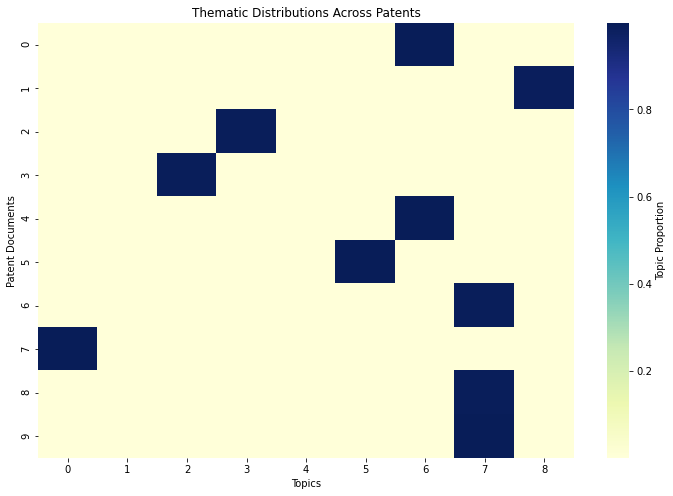

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw a heatmap with the numeric values in each cell
sns.heatmap(df_distributions, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Topic Proportion'})

plt.title('Thematic Distributions Across Patents')
plt.xlabel('Topics')
plt.ylabel('Patent Documents')
plt.show()


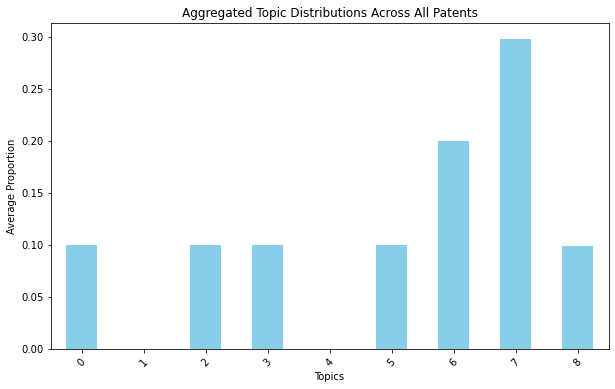

In [105]:
aggregated_distributions.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Aggregated Topic Distributions Across All Patents')
plt.xlabel('Topics')
plt.ylabel('Average Proportion')
plt.xticks(rotation=45)
plt.show()


Identifying Rare Topic Distribution

In [106]:
# Convert the list of lists into a DataFrame
df_distributions = pd.DataFrame(normalized_distributions)

# Calculate the mean topic proportion across all documents
aggregated_distributions = df_distributions.mean()

# Identify topics with low average proportions across the portfolio
low_prevalence_topics = aggregated_distributions[aggregated_distributions < aggregated_distributions.quantile(0.4)]

# Print out these topics and their average proportions
print("Rare Topics and Their Average Proportions Across Documents:")
print(low_prevalence_topics)


Rare Topics and Their Average Proportions Across Documents:
1    0.000646
3    0.100000
4    0.000646
8    0.099570
dtype: float64


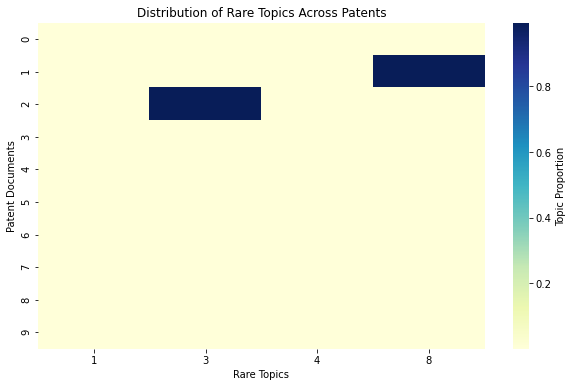

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame to include only the rare topics
rare_topics_distributions = df_distributions[low_prevalence_topics.index]

# Visualize these distributions with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rare_topics_distributions, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Topic Proportion'})
plt.title('Distribution of Rare Topics Across Patents')
plt.xlabel('Rare Topics')
plt.ylabel('Patent Documents')
plt.show()


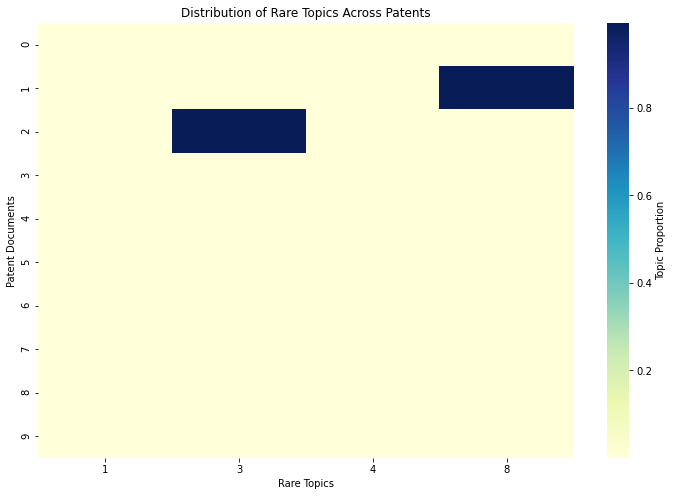

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

rare_topics_distributions = df_distributions[low_prevalence_topics.index]

# Draw a heatmap with the numeric values in each cell
sns.heatmap(rare_topics_distributions, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Topic Proportion'})

plt.title('Distribution of Rare Topics Across Patents')
plt.xlabel('Rare Topics')
plt.ylabel('Patent Documents')
plt.show()

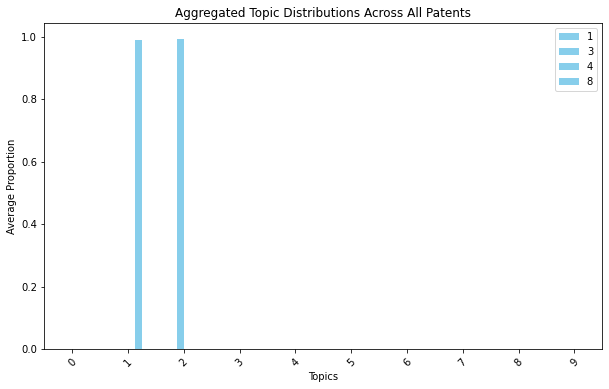

In [109]:
rare_topics_distributions.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Aggregated Topic Distributions Across All Patents')
plt.xlabel('Topics')
plt.ylabel('Average Proportion')
plt.xticks(rotation=45)
plt.show()

Pairwise Comparison

In [110]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [111]:
# Ensure df_distributions is your DataFrame of normalized topic proportions
# Assuming normalized_distributions is already defined as your list of lists
df_distributions = pd.DataFrame(normalized_distributions)

# Calculate the pairwise cosine similarity between all documents
cosine_sim_matrix = cosine_similarity(df_distributions)

# Convert the numpy matrix back to a DataFrame for easier handling
cosine_sim_df = pd.DataFrame(cosine_sim_matrix)



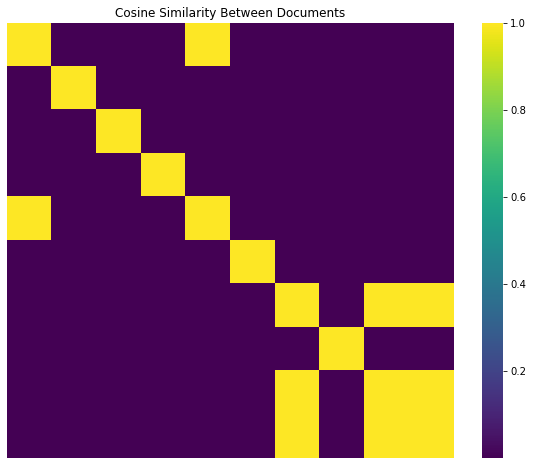

In [112]:
# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_df, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Cosine Similarity Between Documents')
plt.show()

In [113]:
# Threshold for considering a document to have a unique theme
unique_threshold = 0.9999999

# Identify documents with low maximum similarity to others (excluding self-comparison)
unique_docs = cosine_sim_df.apply(lambda row: max(row.drop(row.name)), axis=1) < unique_threshold

# Print the indices of patents considered to have unique themes
print("Documents with Unique Themes:")
print(unique_docs[unique_docs].index.tolist())

Documents with Unique Themes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [114]:
# Threshold for considering a document to have a unique theme
unique_threshold = 0.5

# Identify documents with low maximum similarity to others (excluding self-comparison)
unique_docs = cosine_sim_df.apply(lambda row: max(row.drop(row.name)), axis=1) < unique_threshold

# Print the indices of patents considered to have unique themes
print("Documents with Unique Themes:")
print(unique_docs[unique_docs].index.tolist())


Documents with Unique Themes:
[1, 2, 3, 5, 7]


In [120]:
# Threshold for considering a document to have a unique theme
unique_threshold = 0.002

# Identify documents with low maximum similarity to others (excluding self-comparison)
unique_docs = cosine_sim_df.apply(lambda row: max(row.drop(row.name)), axis=1) < unique_threshold

# Print the indices of patents considered to have unique themes
print("Documents with Unique Themes:")
print(unique_docs[unique_docs].index.tolist())

Documents with Unique Themes:
[2, 3, 5, 7]


In [121]:
# Threshold for considering a document to have a unique theme
unique_threshold = 0.0015

# Identify documents with low maximum similarity to others (excluding self-comparison)
unique_docs = cosine_sim_df.apply(lambda row: max(row.drop(row.name)), axis=1) < unique_threshold

# Print the indices of patents considered to have unique themes
print("Documents with Unique Themes:")
print(unique_docs[unique_docs].index.tolist())

Documents with Unique Themes:
[5]


Overlap and Gap Identification

In [154]:
# High threshold for overlaps
overlap_threshold = 0.25

# Low threshold for gaps
gap_threshold = 0.3

# Identify documents with significant overlaps
overlaps = cosine_sim_df.apply(lambda row: row > overlap_threshold).sum() > 1

# Identify documents with unique themes representing gaps
gaps = cosine_sim_df.apply(lambda row: max(row.drop(row.name)) < gap_threshold)

print("Documents with Significant Overlaps:", overlaps[overlaps].index.tolist())
print("Documents Representing Thematic Gaps:", gaps[gaps].index.tolist())


Documents with Significant Overlaps: [0, 4, 6, 8, 9]
Documents Representing Thematic Gaps: [1, 2, 3, 5, 7]


IndexError: Inconsistent shape between the condition and the input (got (10, 1) and (10,))

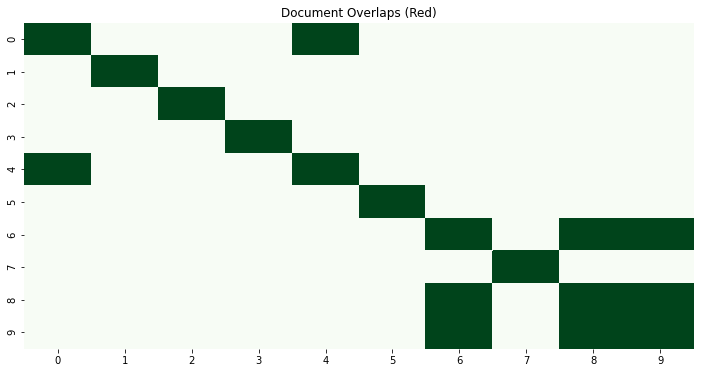

<Figure size 864x432 with 0 Axes>

In [155]:
# Visualization of overlaps and gaps
plt.figure(figsize=(12, 6))

# Plotting overlaps
sns.heatmap(cosine_sim_df.apply(lambda x: x > overlap_threshold), cmap="Greens", cbar=False)
plt.title('Document Overlaps (Red)')

plt.figure(figsize=(12, 6))

# Plotting gaps
sns.heatmap(cosine_sim_df.apply(lambda x: max(x.drop(x.name)) < gap_threshold), cmap="OrRd", cbar=False)
plt.title('Document Gaps (Blue)')

plt.show()

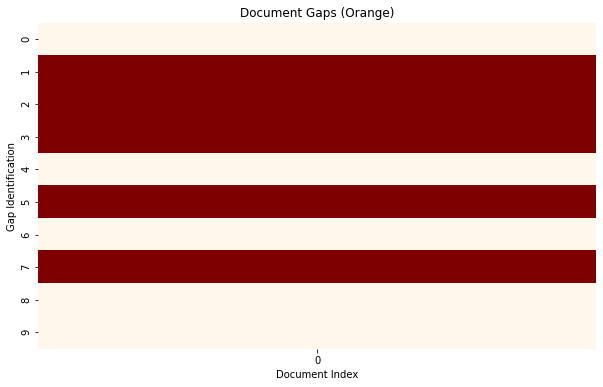

In [156]:
# Identifying thematic gaps based on the gap_threshold
gap_mask = cosine_sim_df.apply(lambda row: max(row.drop(row.name)) < gap_threshold, axis=1)

# Preparing a mask for visualization
gap_visualization_mask = pd.DataFrame([gap_mask]).T  # Transpose to match the heatmap dimensions

# Now, visualize the gaps using this mask
plt.figure(figsize=(10, 6))
sns.heatmap(gap_visualization_mask, cmap="OrRd", cbar=False)
plt.title('Document Gaps (Orange)')
plt.xlabel('Document Index')
plt.ylabel('Gap Identification')
plt.show()



In [157]:
# Calculate maximum similarity for each document excluding self-comparison
max_similarity_scores = cosine_sim_df.apply(lambda row: np.max(row.drop(index=row.name)), axis=1)

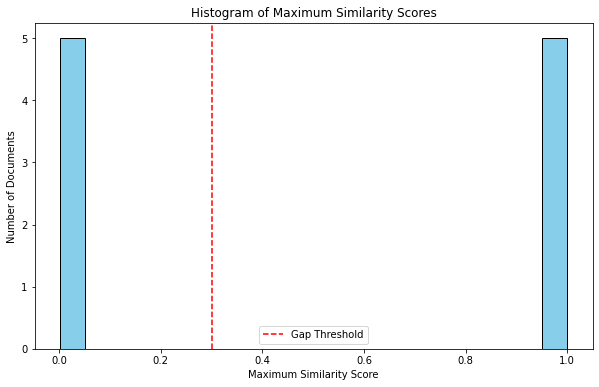

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(max_similarity_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Maximum Similarity Scores')
plt.xlabel('Maximum Similarity Score')
plt.ylabel('Number of Documents')
plt.axvline(x=gap_threshold, color='red', linestyle='--', label='Gap Threshold')
plt.legend()
plt.show()


In [159]:
# Identify documents representing thematic gaps
gap_documents = max_similarity_scores[max_similarity_scores < gap_threshold].index.tolist()

print("Documents Representing Thematic Gaps:", gap_documents)


Documents Representing Thematic Gaps: [1, 2, 3, 5, 7]


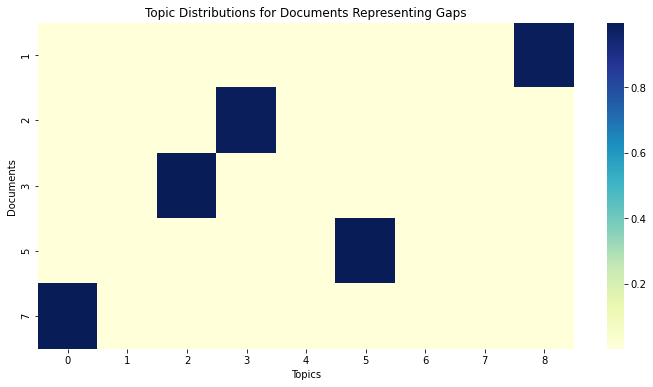

In [162]:
# Assuming 'gap_docs' contains the indices of documents identified as gaps
gap_docs = gap_documents  # Example indices

# Analyze topic distributions for gap documents
gap_distributions = df_distributions.iloc[gap_docs]

# Visualize topic distributions for documents representing gaps
plt.figure(figsize=(12, 6))
sns.heatmap(gap_distributions, cmap="YlGnBu")
plt.title('Topic Distributions for Documents Representing Gaps')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.show()

# Consult with domain experts to validate and explore these gaps further
# This step is beyond code and involves strategic and creative thinking


In [165]:
# Assuming 'gap_docs' contains the indices of documents identified as gaps
gap_docs = gap_docs  # Example indices

# Analyze topic distributions for gap documents
gap_distributions = df_distributions.iloc[gap_docs]

# Visualize topic distributions for documents representing gaps
plt.figure(figsize=(12, 6))
sns.heatmap(gap_distributions, cmap="YlGnBu")
plt.title('Topic Distributions for Documents Representing Gaps')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.show()

# Consult with domain experts to validate and explore these gaps further
# This step is beyond code and involves strategic and creative thinking

NotImplementedError: iLocation based boolean indexing on an integer type is not available

In [166]:
from scipy.stats import entropy

# Calculate entropy for each document's topic distribution to measure concentration
topic_entropy = gap_distributions.apply(entropy, axis=1)

# Lower entropy indicates more concentrated topic distributions
print("Entropy for each gap document's topic distribution:")
print(topic_entropy)

# Documents with lower entropy can be considered as having more specific (narrow) gaps
specific_gaps = topic_entropy[topic_entropy < topic_entropy.median()]
print("\nDocuments with specific (narrow) gaps:", specific_gaps.index.tolist())


Entropy for each gap document's topic distribution:
1    0.073838
2    0.047243
3    0.046198
5    0.016913
7    0.036936
dtype: float64

Documents with specific (narrow) gaps: [5, 7]


In [171]:
# Assuming the column containing patent numbers is named 'patent_number'
# Replace 'patent_number' with the actual column name if it's different
document_indices = [5, 7]
patent_numbers = results.loc[document_indices, 'publication_number']

print("Patent Numbers for Documents 5 and 7:")
print(patent_numbers)
# Print the column names of the DataFrame
print(results.columns)



Patent Numbers for Documents 5 and 7:
5    US-2015044004-A1
7      US-11156742-B2
Name: publication_number, dtype: object
Index(['publication_number', 'abstract', 'claim', 'top_terms', 'embedding',
       'cpc', 'definitions'],
      dtype='object')


Utilizing Reduced Features for Claim Generation

In [193]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/kaggle/input/cpc-query-result/cpc_query_result.csv')
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [194]:
import pandas as pd
import numpy as np
from gensim.models.phrases import Phrases

# Assuming 'df' is your DataFrame and 'all_data' is prepared as described
# First, let's create a dictionary to map publication numbers to cleaned combined text
pub_number_to_cleaned_text = {
    data['publication_number']: ' '.join(data['tokens'])
    for data in all_data
}

# Now, let's add the cleaned combined text to the DataFrame
df['Cleaned_Combined_Text'] = df['publication_number'].map(pub_number_to_cleaned_text)

# Continue with adding PCA and LDA features to the DataFrame as before
# Example placeholders for demonstration
pca_reduced_features = np.random.rand(len(df), 9)  # Example: 9 PCA features
normalized_topic_distributions = np.random.rand(len(df), 9)  # Example: 9 LDA topics

# Add PCA and LDA features to the DataFrame
for i in range(pca_reduced_features.shape[1]):
    df[f'PCA_Feature_{i}'] = pca_reduced_features[:, i]

for i in range(normalized_topic_distributions.shape[1]):
    df[f'Topic_{i}'] = normalized_topic_distributions[:, i]
print("PCA reduced features and normalized topic distributions added to the DataFrame.")

# Function to convert numerical features to textual representation
def numerical_feature_to_text(value, feature_name):
    if value < 0.25:
        return f"{feature_name}_Low"
    elif value < 0.5:
        return f"{feature_name}_Medium"
    elif value < 0.75:
        return f"{feature_name}_High"
    else:
        return f"{feature_name}_VeryHigh"

# Convert PCA and LDA features to textual format
for i in range(pca_reduced_features.shape[1]):
    df[f'PCA_Feature_{i}_Text'] = df[f'PCA_Feature_{i}'].apply(lambda x: numerical_feature_to_text(x, f'PCA_Feature_{i}'))

for i in range(normalized_topic_distributions.shape[1]):
    df[f'Topic_{i}_Text'] = df[f'Topic_{i}'].apply(lambda x: numerical_feature_to_text(x, f'Topic_{i}'))
print("Numerical features converted to textual representations.")

# Combine all textual inputs and embedded feature representations into a single column
df['Enhanced_Combined_Input'] = df['Cleaned_Combined_Text'] + ' ' + df[[f'PCA_Feature_{i}_Text' for i in range(pca_reduced_features.shape[1])] + [f'Topic_{i}_Text' for i in range(normalized_topic_distributions.shape[1])]].apply(lambda row: ' '.join(row.values), axis=1)

print("Enhanced combined textual input prepared for model training.")
print("Sample enhanced combined input:", df['Enhanced_Combined_Input'].iloc[8])


PCA reduced features and normalized topic distributions added to the DataFrame.
Numerical features converted to textual representations.
Enhanced combined textual input prepared for model training.
Sample enhanced combined input: downhole_tool acoustic transducer downhole_measurement backing_contact inner_surface transducer structure_coupled_housing structure_coupled_housing portion coupled_structure coupled_structure structure_coupled degree freedom relative extends longitudinally backing portion compressional force housing transferred structure backing canister_contact_outer_surface transducer exerts radial_force_transducer exposed pressure_higher_atmospheric_pressure apparatus_downhole_acoustic_tool transducer operable emitting acoustic_excitation_signal and/or receiving echo_signal_perform_downhole measurement_backing contact_inner surface_transducer acoustically transparent canister forming external surface downhole_acoustic tool canister_contact_outer_surface transducer configure

GPT-2 Model Training

In [196]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")


GPU not available, using CPU instead.


In [198]:
import pandas as pd
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

print("Starting the process...")

# Load your dataset
print("Loading dataset...")
df = pd.read_csv('/kaggle/input/cpc-query-result/cpc_query_result.csv')  # Update this path
print("Dataset loaded.")

# Check and prepare 'Enhanced_Combined_Input'
if 'Enhanced_Combined_Input' not in df.columns:
    print("'Enhanced_Combined_Input' column missing, creating it...")
    # This is a placeholder - replace with your actual logic to create 'Enhanced_Combined_Input'
    df['Enhanced_Combined_Input'] = df['abstract'] + ' ' + df['claim']  # Simplify for example
    print("'Enhanced_Combined_Input' column created.")

# Assuming 'Enhanced_Combined_Input' is now correctly in your DataFrame
texts = df['Enhanced_Combined_Input'].tolist()

# Saving the texts to a file, which will be used for training
with open('train.txt', 'w') as f:
    f.write('\n'.join(texts))
print("Training texts saved to 'train.txt'.")

# Load tokenizer and model
print("Loading GPT-2 tokenizer and model...")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Prepare dataset and data collator
print("Preparing dataset and data collator...")
train_dataset = TextDataset(tokenizer=tokenizer, file_path="train.txt", block_size=128)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=1,  # Adjust epochs based on your dataset size and training needs
    per_device_train_batch_size=4,  # Adjust based on your GPU memory
    save_steps=10_000,
    save_total_limit=2,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# Start training
print("Starting model training...")
trainer.train()

# Save the fine-tuned model and tokenizer
print("Saving the fine-tuned model and tokenizer...")
model.save_pretrained('./gpt2_finetuned')
tokenizer.save_pretrained('./gpt2_finetuned')

print("Training completed. Model and tokenizer saved.")


Starting the process...
Loading dataset...
Dataset loaded.
'Enhanced_Combined_Input' column missing, creating it...
'Enhanced_Combined_Input' column created.
Training texts saved to 'train.txt'.
Loading GPT-2 tokenizer and model...
Preparing dataset and data collator...
Starting model training...




Saving the fine-tuned model and tokenizer...
Training completed. Model and tokenizer saved.


Creating the Test Data 'Enhanced_Combined_Input'for Comparison with 'Enhanced_Combined_Input' from Trained Model

Model Evaluation

In [206]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd

# Assuming the fine-tuned model and tokenizer are correctly saved at 'model_path'
model_path = '/kaggle/working/gpt2_finetuned'
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)


In [208]:
# Load the test dataset
df_test = pd.read_csv('/kaggle/input/test-dataset/test_dataset.csv')  # Ensure this path is correct
print("Test dataset loaded successfully.")


Test dataset loaded successfully.


In [209]:
# Validate the presence of 'Enhanced_Combined_Input' in df_test
if 'Enhanced_Combined_Input' not in df_test.columns:
    raise KeyError("'Enhanced_Combined_Input' column is missing from the test dataset. Ensure it is correctly generated.")

test_texts = df_test['Enhanced_Combined_Input'].tolist()

# Example of generating predictions for the first test text (Expand this as needed)
inputs = tokenizer.encode(test_texts[0], return_tensors='pt')
with torch.no_grad():
    outputs = model.generate(inputs, max_length=512)
    print("Generated Text:", tokenizer.decode(outputs[0], skip_special_tokens=True))


KeyError: "'Enhanced_Combined_Input' column is missing from the test dataset. Ensure it is correctly generated."

In [205]:
# Assuming you have a DataFrame `df_test` with a column 'Enhanced_Combined_Input' for test data
test_texts = df_test['Enhanced_Combined_Input'].tolist()

KeyError: 'Enhanced_Combined_Input'

In [ ]:
from gensim.corpora import Dictionary
tfidf_texts = []
for record in all_data:  # replace your_data with the list or dictionary you are using
    tfidf_texts.extend([
        record['abstract_bigrams'], 
        record['claim_bigrams'], 
        record['abstract_trigrams'],
        record['claim_trigrams']
    ])
    
print("Length of tfidf_texts:", len(tfidf_texts))
print("Sample data in tfidf_texts:", tfidf_texts[:10])

vectorizer = TfidfVectorizer(min_df=5, max_df=0.9)
tfidf_matrix = vectorizer.fit_transform(tfidf_texts)
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
n = 100
top_n = feature_array[tfidf_sorting][:n]
remove_words = list(set(top_n))
stop_words.update(remove_words)

dictionary = Dictionary(documents)  # Creates a term dictionary of your corpus
corpus = [dictionary.doc2bow(doc) for doc in documents]  # Converts a document into the bag-of-words (BoW) format

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

In [ ]:
# Tokenized bigrams and trigrams for all abstracts and claims
tokenized_data = all_abstract_bigrams + all_claim_bigrams + all_abstract_trigrams + all_claim_trigrams
dictionary = gensim.corpora.Dictionary(tokenized_data)

# Filter out words that occur less than 2 documents or more than 80% of the documents.
print("Dictionary size before filtering: ", len(dictionary))
dictionary.filter_extremes(no_below=2, no_above=0.8)
print("Dictionary size after filtering: ", len(dictionary))

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]

print("Corpus length: ", len(corpus))

# Define function to get topic distributions for a document
def get_document_topics(text):
    # Tokenize, remove stop words and punctuation, and lemmatize text
    tokenized_text = clean_and_tokenize(text)

    # Form Bigrams and Trigrams
    bigram = bigram_transformer[tokenized_text]
    trigram = trigram_transformer[bigram]
    
    # Get bow format of text
    bow_text = dictionary.doc2bow(trigram)
    
    # Get topic distribution of text
    return lda.get_document_topics(bow_text)

In [ ]:
# Train the model with multicore to speed up execution
lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=30, random_state=42, 
                     workers=4, passes=2, batch=False)

In [ ]:
# Print the topics
def display_topics(model, num_topics=40, num_words=20):
    # Adjusting topic numbers to start from 1 and sorting
    topics = model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    topics = sorted(topics, key=lambda x: x[0])  # Sort topics based on topic number
    
    for topic_num, topic_words in topics:
        # Renumber topics starting from 1
        topic_num += 1
        # Format words and weights
        words = ', '.join([f"{word} ({prob:.3f})" for word, prob in topic_words])
        print(f"Topic {topic_num}: {words}\n")

# Example usage
display_topics(lda)


Caluclating Coherence

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


In [ ]:
Calcualting Perplexity

In [ ]:
# Assuming 'corpus' is your document-term matrix for the test set
log_perplexity = lda.log_perplexity(corpus)

# To get the actual perplexity, you can take the exponential of the negative log perplexity
perplexity = np.exp(-log_perplexity)

print(f"Log perplexity of the LDA model: {log_perplexity}")
print(f"Perplexity of the LDA model: {perplexity}")


Identify Topic Distribution

In [ ]:
# Topics distribution
def get_document_topics(text):
    # Tokenize, remove stop words and punctuation, and lemmatize text
    tokenized_text = clean_and_tokenize(text)[1]

    # Form Bigrams and Trigrams
    bigram = bigram_transformer[tokenized_text]
    trigram = trigram_transformer[bigram]
    
    # Get bow format of text
    bow_text = dictionary.doc2bow(trigram)
    
    # Get topic distribution of text
    return lda.get_document_topics(bow_text)

for data in all_data:
    # Concatenate abstract and claim bigrams and trigrams
    text = data['abstract_bigrams'] + ' ' + data['claim_bigrams'] + ' ' + data['abstract_trigrams'] + ' ' + data['claim_trigrams']

    # Get the topic distribution for the text
    data['topics'] = get_document_topics(text)

    # If you just want the topic with the highest probability, uncomment the line below
    # data['topics'] = max(get_document_topics(text), key=lambda x: x[1])
    print(f"Patent {data['publication_number']} has these topic distributions: {data['topics']}")

Preparing Principal Component Analysis

Step 1 Preparing LDA Features 

In [ ]:
import numpy as np

# Assuming 'corpus' is your document-term matrix and 'lda' is your trained LDA model

# Dynamically determine the number of topics from the model
num_topics = lda.num_topics

# Initialize an empty matrix to hold topic distributions for each document
num_documents = len(corpus)
lda_features = np.zeros((num_documents, num_topics))

# Populate the matrix with the topic distribution for each document
for i, doc_topics in enumerate(lda[corpus]):  # Using lda[corpus] directly
    for topic, prob in doc_topics:
        # Assuming topic indices from LDA model are 0-based; adjust if they are 1-based
        lda_features[i, topic] = prob

print(f"Shape of LDA features: {lda_features.shape}")  # Should be (num_documents, num_topics)


In [ ]:
print(f"Number of documents in corpus: {len(corpus)}")


Define Function to Clean Topic Labels

In [ ]:
import re

# Function to clean topic labels for display
def clean_topic_labels_for_display(topic_str):
    # Remove numeric weights and the multiplication symbol "*"
    cleaned_topic = re.sub(r'\d+\.\d+\*', '', topic_str)  # Removes "0.066*" and similar patterns
    return cleaned_topic

Process Topics by Frequency

In [ ]:
# Process Topics and Print Output
import pandas as pd
from collections import Counter, defaultdict

def get_topics_info(all_data, lda_model):
    # Create a dictionary of topics with numeric weights initially
    topics_dict = dict(lda_model.print_topics(num_topics=-1, num_words=10))
    
    # Clean topic labels
    cleaned_topic_labels = {key: clean_topic_labels_for_display(value) for key, value in topics_dict.items()}
    for key, value in cleaned_topic_labels.items():  # Use cleaned_topic_labels for iteration
        cleaned_value = value.replace('_', ' ')  # Replaces underscore with space in each label
        cleaned_topic_labels[key] = cleaned_value  # Update the cleaned_topic_labels with the underscore replaced
    
    patent_topics_info = defaultdict(list)  
    topic_counter = Counter()

    for data in all_data:
        patent = data['publication_number']
        # Assuming 'data.get('topics', [])' returns a list of topic indices for each patent
        topics = [topic for topic, _ in data.get('topics', [])]

        for topic in topics:
            # Fetch and clean the topic label using our cleaned_topic_labels dictionary
            topic_label = cleaned_topic_labels.get(topic, f"Topic {topic}")
            topic_counter.update([topic_label])
            patent_topics_info[topic_label].append(patent)

    return patent_topics_info, topic_counter

# Assuming 'all_data' and 'lda' are already defined and populated
patent_topics_info, topic_counter = get_topics_info(all_data, lda)

topics_sorted_by_frequency = topic_counter.most_common()

# Printing the cleaned and sorted topics
for topic, freq in topics_sorted_by_frequency:
    print(f"Topics: {topic},")
    print(f"Topic frequency: {freq},")
    print(f"Relevant patents: {patent_topics_info[topic]}")
    print("")  # For an empty line between topics for better readability


Normalize Topic Frequencies

In [ ]:
# Example adjustment based on the provided structure of 'all_data'
for patent in all_data:
    # Assuming each 'topics' is a list of (topic, frequency) tuples
    total_topics = sum(freq for _, freq in patent['topics'])
    
    # Normalize the frequencies
    normalized_topics = [(topic, freq / total_topics if total_topics > 0 else 0) for topic, freq in patent['topics']]
    
    # Update the patent data with normalized topics
    patent['normalized_topics'] = normalized_topics

Create a Topic-Proportion Matrix

In [ ]:
import numpy as np

# Assuming all_data is already defined
# Example structure of all_data mentioned previously for reference

# Determine the number of patents and the maximum topic index to size the matrix
num_patents = len(all_data)
max_topic_index = max(max(topic for topic, _ in patent['topics']) for patent in all_data) + 1

print(f"Number of patents: {num_patents}")
print(f"Number of topics: {max_topic_index}")

# Initialize the matrix with zeros
topic_matrix = np.zeros((num_patents, max_topic_index))

# Populate the matrix with raw topic frequencies
for i, patent in enumerate(all_data):
    for topic, frequency in patent['topics']:
        topic_matrix[i, topic] = frequency

print("\nRaw topic matrix (first 5 patents):")
print(topic_matrix[:5])

# Normalize the rows so that topic proportions sum to 1 for each patent
topic_matrix = topic_matrix / topic_matrix.sum(axis=1, keepdims=True)

# Handle potential division by zero issues by replacing NaNs with zeros
topic_matrix = np.nan_to_num(topic_matrix)

print("\nNormalized topic matrix (first 10 patents):")
print(topic_matrix[:10])

# Printing the complete normalized topic matrix can be overwhelming if the dataset is large.
# If you wish to see the entire matrix, remove the slicing ([:5]) in the print statement.
# However, for large datasets, consider printing only a subset or specific entries of interest.



Identify Dominant Topics for Each Patent

In [ ]:
dominant_topics = []

for patent in all_data:
    # Assuming 'topics' is a list of (topic, frequency) tuples
    dominant_topic = sorted(patent['topics'], key=lambda x: x[1], reverse=True)[0][0]
    dominant_topics.append((patent['publication_number'], dominant_topic))

# Print the dominant topic for the first few patents to check
for pub_num, topic in dominant_topics[:10]:
    print(f"Patent {pub_num} has dominant topic: {topic}")


Analyze Topic Overlaps Across Patents

In [ ]:
from collections import defaultdict

topic_patent_map = defaultdict(list)

for pub_num, topic in dominant_topics:
    topic_patent_map[topic].append(pub_num)

# Print the number of patents for each dominant topic
for topic, patents in topic_patent_map.items():
    print(f"Topic {topic} is dominant in {len(patents)} patents")


Clustering Patents Based on Dominant Topics

In [ ]:
# Example: Access patents related to a specific topic
specific_topic = 0  # Change this to the topic number of interest
print(f"Patents related to Topic {specific_topic}: {topic_patent_map[specific_topic]}")


In [ ]:
import numpy as np

# Assuming 'all_data' contains the topic frequencies for each patent
# Let's create a dummy structure for topic frequencies per patent for illustration
# Example: all_data[i]['topic_frequencies'] = [0.1, 0.2, 0.05, ..., 0.05] for i-th patent

# Convert topic frequencies into a numpy array for easier manipulation
topic_frequencies_matrix = np.array([patent['topic_frequencies'] for patent in all_data])

# Normalize the frequencies to get proportions
topic_proportions_matrix = topic_frequencies_matrix / topic_frequencies_matrix.sum(axis=1, keepdims=True)


In [ ]:
# Topics distribution
def get_document_topics(text):
    # Tokenize, remove stop words and punctuation, and lemmatize text
    tokenized_text = clean_and_tokenize(text)[1]

    # Form Bigrams and Trigrams
    bigram = bigram_transformer[tokenized_text]
    trigram = trigram_transformer[bigram]
    
    # Get bow format of text
    bow_text = dictionary.doc2bow(trigram)
    
    # Get topic distribution of text
    return lda.get_document_topics(bow_text)

for data in all_data:
    # Concatenate abstract and claim bigrams and trigrams
    text = data['abstract_bigrams'] + ' ' + data['claim_bigrams'] + ' ' + data['abstract_trigrams'] + ' ' + data['claim_trigrams']

    # Get the topic distribution for the text
    data['topics'] = get_document_topics(text)

    # If you just want the topic with the highest probability, uncomment the line below
    # data['topics'] = max(get_document_topics(text), key=lambda x: x[1])

In [ ]:
for data in all_data: print(f"Patent {data['publication_number']} has these topic distributions: {data['topics']}")

In [ ]:
df = pd.DataFrame(all_data) 
print(df.head()) 

In [ ]:
# Get the topics for a specific patent
patent_id = "US-2017114613-A1"
topics = df[df['publication_number'] == patent_id]['topics'].values[0]

print(f'Topics for {patent_id}: ')
for topic_id, prob in topics:
    topic_terms = get_topic_terms(lda, topic_id)
    print(f'Topic {topic_id} (probability {prob*100}%): {topic_terms}')

In [ ]:
# Function to format the topic label
def make_label(row):
    return ", ".join(row['keywords'])

# Create a mapping from topic_id to topic_label
topic_labels = topics.apply(make_label, axis=1).to_dict()

In [ ]:
topic_labels = {
    0: "Topic Label 1",
    1: "Topic Label 2",
    2: "Topic Label 3",
    3: "Topic Label 4",
    4: "Topic Label 5",
    5: "Topic Label 6",
    6: "Topic Label 7",
    7: "Topic Label 8",
    8: "Topic Label 9",
    9: "Topic Label 10",
    10: "Topic Label 11",
    11: "Topic Label 12",
    12: "Topic Label 13",
    13: "Topic Label 14",
    14: "Topic Label 15",
}

In [ ]:
# Extract all topics
all_topics = df['topics'].explode().apply(lambda x: x[0]).values

from collections import Counter

# Count the frequency of each topic
topic_counter = Counter(all_topics)

# Output topics and their counts sorted by count
for topic_id, count in topic_counter.most_common():
    print(f'{topic_labels[topic_id]}: {count} patents')

In [ ]:
import re

# Make a copy of topic_labels
cleaned_topic_labels = topic_labels.copy()

# Clean topic labels
for key, value in cleaned_topic_labels.items():
    cleaned_value = re.sub(r'\"\*[\d\.]+', '\"', value)  # Removes "*0.077" pattern from each label
    cleaned_value = cleaned_value.replace('_', ' ')  # Replaces underscore with space in each label
    cleaned_topic_labels[key] = cleaned_value

# Then continue with the previous steps using cleaned_topic_labels  instead of topic_labels...

Identify the dominant topic for each patent: 

In [ ]:
# Function to return the topic_id with max probability
def dominant_topic(topics):
    dominant_topic_id, _ = max(topics, key=lambda item: item[1])
    return dominant_topic_id

# Assign dominant topics to each patent
df['dominant_topic'] = df['topics'].apply(dominant_topic)

Create a dictionary mapping topics to their descriptions (using get_topic_terms):

In [ ]:
# Create topic-label map
topic_labels = {topic_id: get_topic_terms(lda, topic_id) for topic_id in range(15)}

Apply these labels to the patents dataframe:

In [ ]:
df['dominant_topic_label'] = df['dominant_topic'].map(topic_labels)

In [ ]:
print(df[['publication_number', 'dominant_topic', 'dominant_topic_label']])

Topics that commonly appear across the portfolio:

In [ ]:
import re

# Make a copy of topic_labels
cleaned_topic_labels = topic_labels.copy()

# Clean topic labels
for key, value in cleaned_topic_labels.items():
    cleaned_value = re.sub(r'\"\*[\d\.]+', '\"', value)  # Removes "*0.077" pattern from each label
    cleaned_value = cleaned_value.replace('_', ' ')  # Replaces underscore with space in each label
    cleaned_topic_labels[key] = cleaned_value

# Then continue with the previous steps using cleaned_topic_labels  instead of topic_labels...

In [ ]:
common_topics = df['dominant_topic'].value_counts().idxmax()
print(f'The dominant topics that commonly appear across the portfolio are: {topic_labels[common_topics]}')

Topics that rarely appear across the portfolio:

In [ ]:
rare_topics = df['dominant_topic'].value_counts().idxmin()
print(f'The dominant topics that rarely show up across the portfolio are: {topic_labels[rare_topics]}')

In [ ]:
# Most common dominant topic across the portfolio
common_topics = df['dominant_topic'].value_counts().idxmax()
print(f"The dominant topic that most commonly appears across the portfolio is: {topic_labels[common_topics]}")

# Least common dominant topic across the portfolio
rare_topics = df['dominant_topic'].value_counts().idxmin()
print(f"The dominant topic that rarely shows up across the portfolio is: {topic_labels[rare_topics]}")

Calculate the percentage of each topic within patents:

In [ ]:
# Dictionary for topics without LDA topic modeling weights
import re

# Make a copy of topic_labels
cleaned_topic_labels = topic_labels.copy()

# Clean topic labels
for key, value in cleaned_topic_labels.items():
    cleaned_value = re.sub(r'\"\*[\d\.]+', '\"', value)  # Removes "*0.077" pattern from each label
    cleaned_value = cleaned_value.replace('_', ' ')  # Replaces underscore with space in each label
    cleaned_topic_labels[key] = cleaned_value

# Then continue with the previous steps using cleaned_topic_labels  instead of topic_labels...

In [ ]:
readable_topic_labels = {id: label.replace('_', ' ') for id, label in cleaned_topic_labels.items()}
df['readable_dominant_topic_label'] = df['dominant_topic'].apply(lambda x: readable_topic_labels.get(x,''))

In [ ]:
df['topic_perc'] = df.groupby(['publication_number', 'dominant_topic'])['dominant_topic'].transform(lambda x: len(x) / df[df.publication_number == x.name[0]].shape[0])

Map topic labels to the topics and format the sentences:

In [ ]:
df['patent_topic_info'] = df.apply(lambda row: f'{row["readable_dominant_topic_label"]} {row["topic_perc"] * 100:.2f}% in patent {row["publication_number"]}', axis=1)

Get the list of patents and their topic distribution for most common and least common topics:

In [ ]:
# Most common dominant topic across the portfolio
most_common_topic = df['dominant_topic'].value_counts().idxmax()
most_common_info = df[df['dominant_topic'] == most_common_topic]['patent_topic_info'].unique()

print("The dominant topic that most commonly appears across the portfolio is:\n{}".format('\n'.join(most_common_info)))

# Least common dominant topic across the portfolio
least_common_topic = df['dominant_topic'].value_counts().idxmin()
least_common_info = df[df['dominant_topic'] == least_common_topic]['patent_topic_info'].unique()

print("The dominant topic that rarely shows up across the portfolio is:\n{}".format('\n'.join(least_common_info)))

In [ ]:
import re

# Make a copy of topic_labels
cleaned_topic_labels = topic_labels.copy()

# Clean topic labels
for key, value in cleaned_topic_labels.items():
    cleaned_value = re.sub(r'\"\*[\d\.]+', '\"', value)  # Removes "*0.077" pattern from each label
    cleaned_value = cleaned_value.replace('_', ' ')  # Replaces underscore with space in each label
    cleaned_topic_labels[key] = cleaned_value

# Then continue with the previous steps using cleaned_topic_labels  instead of topic_labels...

In [ ]:
from collections import Counter

def get_topics_info(all_data, lda_model):
    patent_topics_info = {}
    topics = lda_model.print_topics()
    topic_counter = Counter()

    for data in all_data:
        patent = data['publication_number']

        # Most and least contributing topic in a patent
        max_contributing_topic = max(data['topics'], key=lambda x: x[1])
        min_contributing_topic = min(data['topics'], key=lambda x: x[1])

        # Gather all topics to a counter for common topic calculation
        topic_counter.update([topic for topic, _ in data['topics']])

        # Topic description
        max_contrib_topic_descr = topics[max_contributing_topic[0]]
        min_contrib_topic_descr = topics[min_contributing_topic[0]]

        patent_topics_info[patent] = {
            "Max contributing topic": max_contrib_topic_descr, "Max contributing topic weight": max_contributing_topic[1],
            "Min contributing topic": min_contrib_topic_descr, "Min contributing topic weight": min_contributing_topic[1]
        }

    # Most and least common topic among all the patents
    most_common_topic, _ = topic_counter.most_common(1)[0]  # Most common topic
    least_common_topic, _ = topic_counter.most_common()[:-2:-1][0]  # Least common topic

    most_common_topic_descr = topics[most_common_topic]
    least_common_topic_descr = topics[least_common_topic]

    # Add most and least common topics to each patent
    for patent in patent_topics_info:
        patent_topics_info[patent]["Most common topic"] = most_common_topic_descr
        patent_topics_info[patent]["Least common topic"] = least_common_topic_descr

    return patent_topics_info

# Get the topics info
patent_topics_info = get_topics_info(all_data, lda)

# Print the topics info
for patent, info in patent_topics_info.items():
    print(f"\nFor patent {patent}:\n")
    print("Most contributing topic:")
    print(info['Max contributing topic'], "\nWeight: {:.5f}".format(info["Max contributing topic weight"]))
    print()
print("Most common topic across all patents:")
print(info['Most common topic'])
print()
    

Group the dataframe by patents and then find the most common and the most rare topic for each one

In [ ]:
# Define a function to get the most and least common topics per patent
def get_topics_info(all_data, cleaned_topic_labels):
    patent_topics_info = {}

    for data in all_data:
        patent = data['publication_number']

        # Filter out zero contributing topics
        contributing_topics = [topic for topic in data['topics'] if topic[1] > 0]

        if len(contributing_topics)>0:
            # Select the topic with max and min contribution
            max_contributing_topic = max(contributing_topics, key=lambda x: x[1])
            min_contributing_topic = min(contributing_topics, key=lambda x: x[1])

            # Get the topic description
            max_contrib_topic_descr = cleaned_topic_labels[max_contributing_topic[0]]
            min_contrib_topic_descr = cleaned_topic_labels[min_contributing_topic[0]]

            patent_topics_info[patent] = {
                "Max contributing topic": max_contrib_topic_descr, "Max contributing topic weight": max_contributing_topic[1],
                "Min contributing topic": min_contrib_topic_descr, "Min contributing topic weight": min_contributing_topic[1]
            }

    return patent_topics_info

# Get the topics info
patent_topics_info = get_topics_info(all_data, cleaned_topic_labels)

# Print the topics info
for patent, info in patent_topics_info.items():
    print(f"\nFor patent {patent}:\n")
    print("Most contributing topics:")
    print(info['Max contributing topic'], "\nWeight: {:.5f}".format(info["Max contributing topic weight"]))
    print()

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install pyLDAvis --upgrade

In [ ]:
import pandas as pd
print(pd.__version__)

In [ ]:
!pip install pandas==1.2.5
!pip install pyLDAvis==3.3.1

In [ ]:
!pip install pandas --upgrade

In [ ]:
!pip install --upgrade numexpr

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(topics): 
    for idx, topic in topics:
        print(f'Word Cloud for Topic #{idx + 1}') 
        plt.figure(figsize=(5,20)) 
        cloud = WordCloud(background_color='white').generate(" ".join([word for word, _ in topic]))
        plt.imshow(cloud)
        plt.axis('off') 
        plt.show()

# 'lda' should be your trained gensim LdaModel
topics = lda.show_topics(num_words=10, formatted=False)
plot_wordcloud(topics)

# Knowledge Graph for 10 patents; SCHLUMBERGER TECHNOLOGY CORP; CPC is E21B

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
G = nx.Graph()

In [ ]:
for patent in all_data:
    publication_number = patent['publication_number']
    G.add_node(publication_number)
    
    # Link patent to other properties: here, I will illustrate with 'top_terms'
    for top_term in patent['top_terms']:
        G.add_node(top_term)
        G.add_edge(publication_number, top_term)

In [ ]:
for index, topic in enumerate(topics):
    topic_number = f"Topic-{index}"
    G.add_node(topic_number)
    for term_weight in topic[1].split('+'):
        term = term_weight.split('*')[1].replace('"', '').strip()
        if term in G:  # add edge only if term exists in the graph (is a 'top_term' of some patent)
            G.add_edge(topic_number, term)

In [ ]:
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes, you can try different seed if not happy with current layout
nx.draw(G, pos, with_labels=True, font_size=8, node_size=100)
plt.show()

In [ ]:
!pip install plotly

In [ ]:
import networkx as nx 
import plotly.graph_objects as go 
G = nx.Graph()

In [ ]:
# Add nodes and edges for patents and top_terms
for patent in all_data:
    publication_number = patent['publication_number']
    G.add_node(publication_number, type='patent')

    for top_term in patent['top_terms']:
        if not G.has_node(top_term):
            G.add_node(top_term, type='term')
        G.add_edge(publication_number, top_term)

# Add nodes and edges for topics
for index, topic in enumerate(topics):
    topic_number = f"Topic-{index}"
    G.add_node(topic_number, type='topic')

    for term_weight in topic[1].split('+'):
        term = term_weight.split('*')[1].replace('"', '').strip()
        if G.has_node(term):  # add edge only if term node exists
            G.add_edge(topic_number, term)

In [ ]:
# Generate position of the nodes
pos = nx.spring_layout(G)

# Create node traces
node_x = [pos[n][0] for n in G.nodes()]
node_y = [pos[n][1] for n in G.nodes()]
node_text = [n for n in G.nodes()]

# Color node points based on type property
node_marker = dict(
    size=10,
    line_width=2,
    color=['blue' if G.nodes[n]['type'] == 'patent' else 'red' for n in G.nodes()]
)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition='bottom center',
    hoverinfo='text',
    marker=node_marker
)

# Create edge traces
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Create a layout
layout = go.Layout(
    showlegend=False,
    hovermode='closest',
    margin=dict(b=10, l=5, r=5, t=20),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    plot_bgcolor='white'
)

fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
fig.show()

In [ ]:
import plotly.graph_objects as go

# Assuming that 'all_data' is a list of dictionaries containing patent data

# Initialize empty lists to hold the graph data
nodes = []   # will hold both patents and terms
edges = []   # will hold tuples representing edges between patents and terms

# Add patents and their top_terms to the nodes list; create respective edges
for patent_data in all_data:
    patent_number = patent_data['publication_number']
    top_terms = patent_data['top_terms'].split()  # split the string into a list

    if patent_number not in nodes:
        nodes.append(patent_number)

    for term in top_terms:
        if term not in nodes:
            nodes.append(term)

        # Add an edge between the patent and the term
        edges.append((patent_number, term))

# Create the Plotly graph object
G = go.Figure(data=[go.Scatter3d(x=[node for node in nodes],
                                y=[edge[0] for edge in edges],
                                z=[edge[1] for edge in edges],
                                mode='lines+markers',
                                line=dict(width=2, color='darkblue'))
                                ])

# Update layout and show the graph
G.update_layout(template='plotly_dark', title_text="Patents & Terms Graph", width=800, height=800)
G.show()

In [ ]:
import numpy as np 
import seaborn as sns; sns.set_theme()

# Create a matrix of zeros of number_patents x number_patents
# Assuming all_data is your list of patents 
number_patents = len(all_data)
overlap_matrix = np.zeros((number_patents, number_patents))

# Calculate the overlap coefficient for each pair of patents 
for i in range(number_patents):
    for j in range(i+1, number_patents): # No need to calculate the diagonal and repeat calculations
        patent1_keywords = set(all_data[i]['keywords'])
        patent2_keywords = set(all_data[j]['keywords'])
        
        overlap_coefficient = len(patent1_keywords.intersection(patent2_keywords)) / min(len(patent1_keywords), len(patent2_keywords))
        overlap_matrix[i][j] = overlap_matrix[j][i] = overlap_coefficient

# Plot the heatmap
ax = sns.heatmap(
    overlap_matrix, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
samples = [doc for doc in corpus if not all(isinstance(item, tuple) and len(item) == 2 for item in doc)]
for sample in samples:
    print(sample)

In [ ]:
# Get the most relevant patents for the given topic weights.
weights = {0: 0.5, 1: 0.2, 2: 0.3}
relevant_patents = []

for doc_id, doc_bow in enumerate(corpus):
    doc_topics = lda.get_document_topics(doc_bow, minimum_probability=0)
    relevant_patents.append((doc_id, doc_topics))

relevant_patents = sorted(relevant_patents, key=lambda x: sum([weight * prob for i, prob in x[1] if i in weights]), reverse=True)

Degree Centrality: This is simply the number of edges connected to a node. In your patent-term-topic graph, a patent node with high degree centrality means the patent is associated with a large number of terms, and likewise, a high degree centrality for a term indicates the term is used in a large number of patents. High degree centrality nodes are often important nodes in your networks.

In [ ]:
# Returns a dictionary where keys are nodes and values are the degree centrality of the nodes
import operator

degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality
degree_sorted = sorted(degree_centrality.items(), key=operator.itemgetter(1), reverse=True)

# Print top 5 nodes with highest degree centrality
for i in degree_sorted[:5]:
    print(f"Node: {i[0]} has a degree centrality of {i[1]}")

In [ ]:
degree_dict = dict(G.degree(G.nodes()))
degree_sorted_raw = sorted(degree_dict.items(), key=operator.itemgetter(1), reverse=True)

# Print top 5 nodes with highest degree
for i in degree_sorted_raw[:5]:
    print(f"Node: {i[0]} has a degree of {i[1]}")

In [ ]:
import networkx as nx
from collections import Counter

# List of high degree patents
high_degree_patents = ["US-2008314589-A1", "US-2023333275-A1", "US-2017269262-A1", "US-2008236840-A1", "US-2015044004-A1"]

# Collect all terms connected to the high-degree patents
all_terms = []
for patent in high_degree_patents:
    # Get neighbors (terms) of a patent
    terms = list(G.neighbors(patent))
    all_terms.extend(terms)

# Count the frequencies of each term
term_counts = Counter(all_terms)

# Print top 10 most common terms
common_terms = term_counts.most_common(10)
print("Top 10 most common terms:")
for term, freq in common_terms:
    print(f"Term: {term}, Frequency: {freq}")

# Print top 5 least common terms
least_common_terms = term_counts.most_common()[:-6:-1]
print("\nTop 5 least common terms:")
for term, freq in least_common_terms:
    print(f"Term: {term}, Frequency: {freq}")

# Simple Patent Data

In [ ]:
# All of the standard patent data is available in bigquery such as publication/
# grant/filing/priority date, inventors, assignees, cpc/ipc/etc codes, citations

df = client.query("""
SELECT title, publication_number, ARRAY_LENGTH(`cited_by`) AS cited_count, cpc_field.code FROM `patents-public-data.google_patents_research.publications`, UNNEST(cpc) AS cpc_field WHERE cpc_field.code = 'H01M2220/20' group by publication_number, cited_count, cpc_field.code, title order by cited_count DESC LIMIT 1000""").to_dataframe()
df

In [ ]:

df2

In [ ]:
description

In [ ]:
df.to_csv('/kaggle/working/battery_patents4.csv')

In [ ]:
# Some of the fields are nested and can be either unnested in bigquery or
# python. Here we unnest all of the cpc and citation data. The unnesting of two
# fields creates a cross join between them, so even for a single patent a lot
# of rows are created.

df = client.query("""

SELECT 
  pubs.publication_number, 
  pubs.filing_date,
  cpc.code as cpc_code, 
  cpc.first as cpc_first,
  cpc.inventive as cpc_inventive,
  cite.publication_number AS cite_pub,
  cite.filing_date AS cite_filing_date
FROM 
  `patents-public-data.patents.publications` AS pubs,
  UNNEST(citation) AS cite,
  UNNEST(cpc) AS cpc
WHERE 
  pubs.publication_number = "US-8000000-B2"
  """).to_dataframe()


In [ ]:
df.head(20)

# Gathering Some Unique Text, Top Terms, Embeddings Data

In [ ]:
 # There is a lot of more detailed patent data that can be obtained,
 # such as the full text of the patent (title, abstract, claims, description),
 # its top terms and a 64 dimension embedding representation.
 
df = client.query("""

SELECT 
  pubs.publication_number,
  abstract.text AS abstract,
  claims.text AS claim,
  top_terms,
  embedding_v1 AS embedding
FROM 
  `patents-public-data.patents.publications` AS pubs
    INNER JOIN `patents-public-data.google_patents_research.publications` AS res ON 
      pubs.publication_number = res.publication_number,
    UNNEST(abstract_localized) AS abstract,
    UNNEST(claims_localized) AS claims
WHERE 
  pubs.publication_number = "US-8000000-B2"
  """).to_dataframe()

In [ ]:
df

# Build More Advanced Models

### Similarity Between Patents

In [ ]:
# Get Embeddings for a random set of patents

df = client.query("""
SELECT 
  publication_number,
  embedding_v1 as embedding
FROM 
  `patents-public-data.google_patents_research.publications`
WHERE 
  country = "United States"
  AND RAND() < 0.1
LIMIT
  100""").to_dataframe()

In [ ]:
# Compute similarity between the patents.
emb = df.embedding.to_list()
pairwise.cosine_similarity(emb, emb)

### Cluster Patents

In [ ]:
# We can cluster the embeddings too
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(emb)
kmeans.labels_

### CPC Classifier With Embeddings

In [ ]:
# We fetch the embeddings for 10000 random US patents and use the first
# letter of the cpc code as the classification for a patent.

df = client.query("""

SELECT 
  publication_number,
  embedding_v1,
  SUBSTR(cpc.code, 0, 1) AS cpc_class
FROM 
  `patents-public-data.google_patents_research.publications`,
  UNNEST(cpc) AS cpc
WHERE 
  country = "United States"
  AND RAND() < 0.1
LIMIT
  10000""").to_dataframe()

In [ ]:
cpc_classes = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'Y': 8}
classes = tf.convert_to_tensor([cpc_classes[x] for x in df.cpc_class.tolist()])

inputs = tf.convert_to_tensor(df.embedding_v1.tolist())

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(len(cpc_classes))
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(x=inputs,  y=classes, epochs=10, validation_split=0.1)

### CPC Classifier With Abstract Text

In [ ]:
# For another set of 10000 random US patents we fetch the abstract text and
# use the first letter of the cpc code for the classification.

df = client.query("""

SELECT 
  publication_number,
  abstract,
  SUBSTR(cpc.code, 0, 1) AS cpc_class
FROM 
  `patents-public-data.google_patents_research.publications`,
  UNNEST(cpc) AS cpc
WHERE 
  country = "United States"
  AND RAND() < 0.1
LIMIT
  100000""").to_dataframe()

In [ ]:
cpc_classes = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'Y': 8}
classes = tf.convert_to_tensor([cpc_classes[x] for x in df.cpc_class.tolist()])

vocab_size = 1000
emb_size = 16
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    df.abstract.tolist(), vocab_size)

In [ ]:
msl = 100  # max sequence length
inputs = [tokenizer.encode(x) for x in df.abstract.tolist()]
inputs = [x[:msl] if len(x) > msl else x + [0]*(msl-len(x)) for x in inputs]
inputs = tf.convert_to_tensor(inputs)

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, emb_size),
  tf.keras.layers.Conv1D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(len(cpc_classes))
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(x=inputs, y=classes, epochs=10, validation_split=0.1)

**Copyright 2020 Google LLC**

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.